In [52]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [53]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [54]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [55]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [56]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [57]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [58]:
df = pd.read_csv("Numerical_Encoding_Train_HR_Employee_Attrition.csv")

In [59]:
df

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,2,9,4,2,0,3,3,11,...,17,3,0,2,2,8,7,156.613636,0.387172,2.6
1,36,0,2,1,1,2,0,3,5,8,...,14,3,1,3,3,1,8,157.942308,0.411421,2.8
2,25,0,3,16,3,3,0,3,2,5,...,25,3,1,4,3,1,5,448.055556,0.704402,3.2
3,33,0,2,5,4,2,0,3,1,4,...,14,2,0,1,3,3,7,271.907692,0.841632,2.4
4,31,0,2,9,2,3,1,3,1,3,...,12,3,0,2,3,10,2,106.373333,0.207947,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,2,12,3,3,1,4,1,2,...,15,4,0,2,3,10,0,282.466667,0.789828,3.2
879,37,0,2,16,2,4,1,4,1,3,...,13,2,2,3,2,17,0,76.291667,0.711223,3.2
880,33,1,1,6,4,2,1,1,2,5,...,18,2,0,2,2,11,7,272.881579,0.751820,2.0
881,33,0,2,4,1,3,0,2,2,5,...,12,1,0,2,4,3,2,208.666667,0.862289,2.2


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   BusinessTravel            883 non-null    int64  
 3   DistanceFromHome          883 non-null    int64  
 4   Education                 883 non-null    int64  
 5   EnvironmentSatisfaction   883 non-null    int64  
 6   Gender                    883 non-null    int64  
 7   JobInvolvement            883 non-null    int64  
 8   JobLevel                  883 non-null    int64  
 9   JobRole                   883 non-null    int64  
 10  JobSatisfaction           883 non-null    int64  
 11  MonthlyIncome             883 non-null    int64  
 12  NumCompaniesWorked        883 non-null    int64  
 13  OverTime                  883 non-null    int64  
 14  PercentSal

In [61]:
df.describe()

,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,2.062288,9.201586,2.886750,2.684032,0.388448,2.750849,1.919592,4.371461,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245826,0.463811,2.724575
std,8.266129,0.378698,0.512402,8.241818,1.008285,1.092567,0.487674,0.729354,1.007506,2.290214,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196628,0.320030,0.438169
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.043478,0.000000,1.200000
25%,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,3.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630208,0.129730,2.400000
50%,35.000000,0.000000,2.000000,7.000000,3.000000,3.000000,0.000000,3.000000,2.000000,4.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.279070,0.528359,2.800000
75%,42.000000,0.000000,2.000000,14.000000,4.000000,4.000000,1.000000,3.000000,2.000000,5.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.906250,0.762560,3.000000
max,60.000000,1.000000,3.000000,29.000000,5.000000,4.000000,1.000000,4.000000,5.000000,11.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.976744,0.951396,4.000000


<h3>Feature selection</h3>

In [62]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.062422
RelationshipSatisfaction                           0.017751
StockOptionLevel                                   0.014132
JobSatisfaction                                    0.013208
YearsAtCompany                                     0.008229
NumCompaniesWorked                                 0.007066
JobLevel                                           0.005773
YearsInCurrentRole                                 0.004824
TaxRate                                            0.004180
OverallSatisfaction                                0.003831
Age                                                0.003109
JobInvolvement                                     0.002639
DistanceFromHome                                   0.002626
MonthlyHours                                       0.001997
JobRole                                            0.001240
BusinessTravel                                     0.000275
TrainingTimesLastYear                   

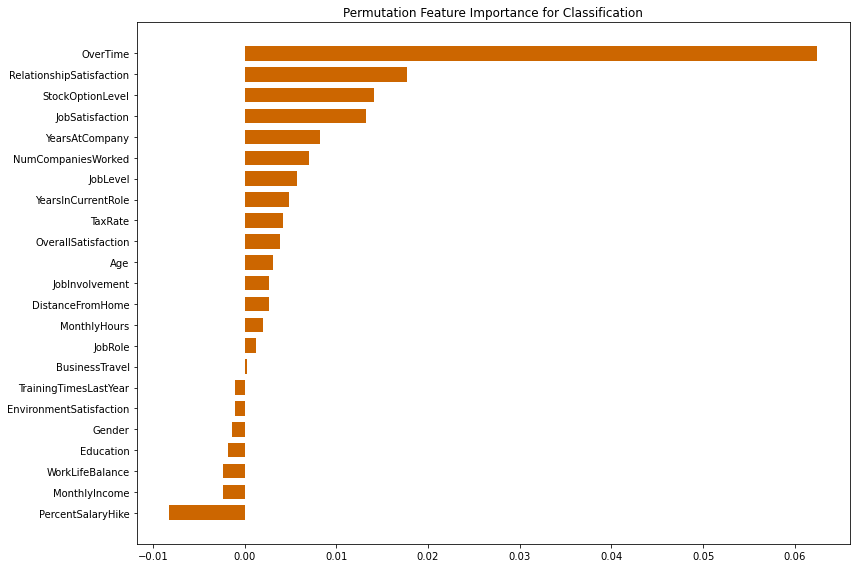

In [63]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [64]:
df = df.drop(['YearsInCurrentRole','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel','PercentSalaryHike','TaxRate'], axis = 1)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       883 non-null    int64  
 1   Attrition                 883 non-null    int64  
 2   DistanceFromHome          883 non-null    int64  
 3   EnvironmentSatisfaction   883 non-null    int64  
 4   JobInvolvement            883 non-null    int64  
 5   JobLevel                  883 non-null    int64  
 6   JobRole                   883 non-null    int64  
 7   JobSatisfaction           883 non-null    int64  
 8   NumCompaniesWorked        883 non-null    int64  
 9   OverTime                  883 non-null    int64  
 10  RelationshipSatisfaction  883 non-null    int64  
 11  StockOptionLevel          883 non-null    int64  
 12  TrainingTimesLastYear     883 non-null    int64  
 13  WorkLifeBalance           883 non-null    int64  
 14  OverallSat

<h3>Discretization</h3>

Continuous features to discretize:
- <b>Age</b>
- <b>DistanceFromHome</b>
- <b>YearsAtCompany</b>
- <b>YearsInCurrentRole</b>
- <b>NumCompaniesWorked</b>
- <b>MonthlyIncome</b>
- <b>MonthlyHours</b>
- <b>PercentSalaryHike</b>

In [66]:
columns_to_discretize = ['Age','DistanceFromHome','YearsAtCompany','YearsInCurrentRole',
'NumCompaniesWorked','MonthlyIncome','MonthlyHours','PercentSalaryHike']

In [67]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,11,3,9,0,3,0,2,2,2.6
1,36,0,1,2,3,5,8,3,1,1,3,1,3,3,2.8
2,25,0,16,3,3,2,5,4,1,1,3,1,4,3,3.2
3,33,0,5,2,3,1,4,2,2,0,2,0,1,3,2.4
4,31,0,9,3,3,1,3,4,1,0,3,0,2,3,3.2


In [68]:
for column in columns_to_discretize:
    if column in df:
        df[column] = pd.qcut(df[column], q=4, duplicates='drop', labels=False)

In [69]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,3,0,2,2,3,3,11,3,3,0,3,0,2,2,2.6
1,2,0,0,2,3,5,8,3,0,1,3,1,3,3,2.8
2,0,0,3,3,3,2,5,4,0,1,3,1,4,3,3.2
3,1,0,1,2,3,1,4,2,1,0,2,0,1,3,2.4
4,1,0,2,3,3,1,3,4,0,0,3,0,2,3,3.2


<h3>Divide into features and target</h3>

In [70]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [71]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.5986759799833193
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


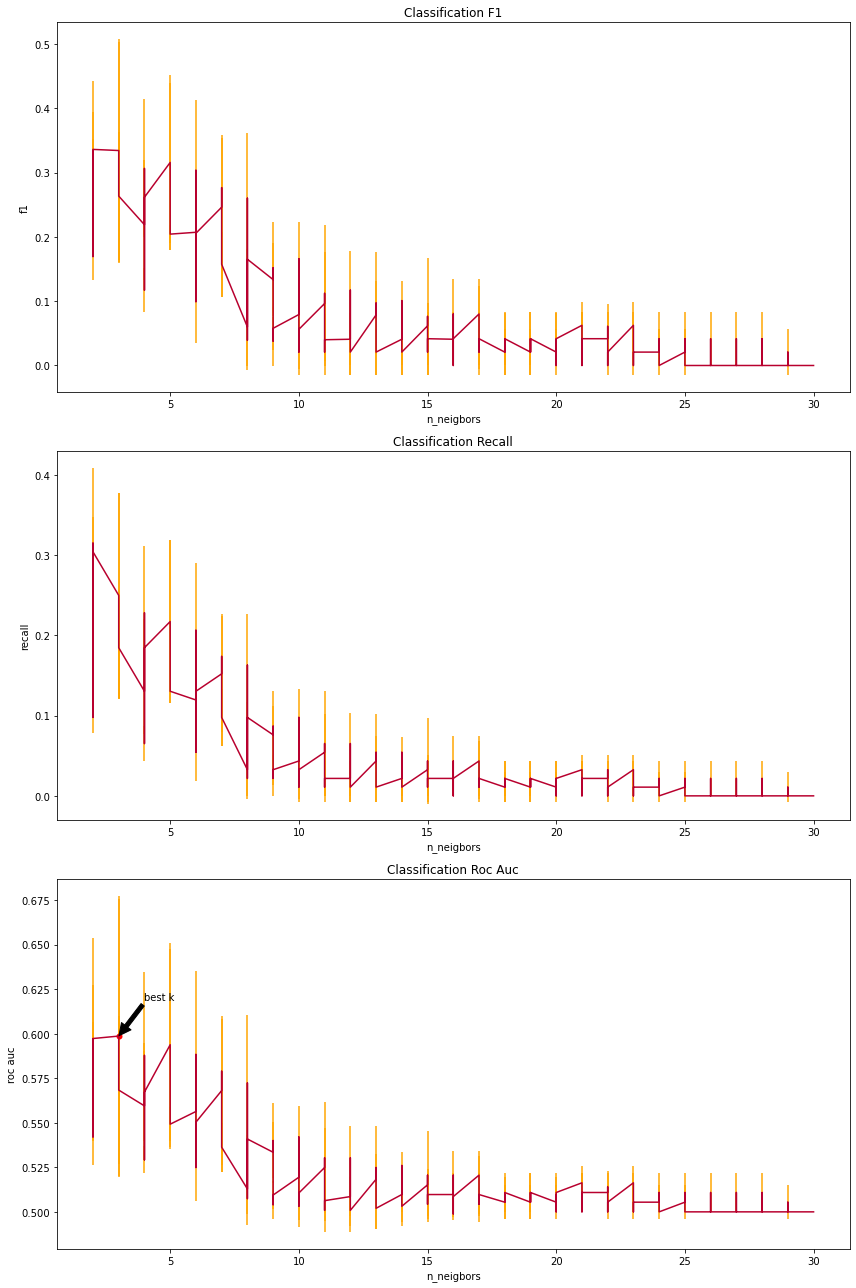



Permutation importances of the training set

OverTime                                           0.027377
RelationshipSatisfaction                           0.009798
EnvironmentSatisfaction                            0.007765
JobRole                                            0.007678
NumCompaniesWorked                                 0.007535
JobSatisfaction                                    0.006964
WorkLifeBalance                                    0.006263
StockOptionLevel                                   0.005793
DistanceFromHome                                   0.005672
JobLevel                                           0.004320
JobInvolvement                                     0.002119
Age                                                0.000805
OverallSatisfaction                                -0.004329
TrainingTimesLastYear                              -0.006534



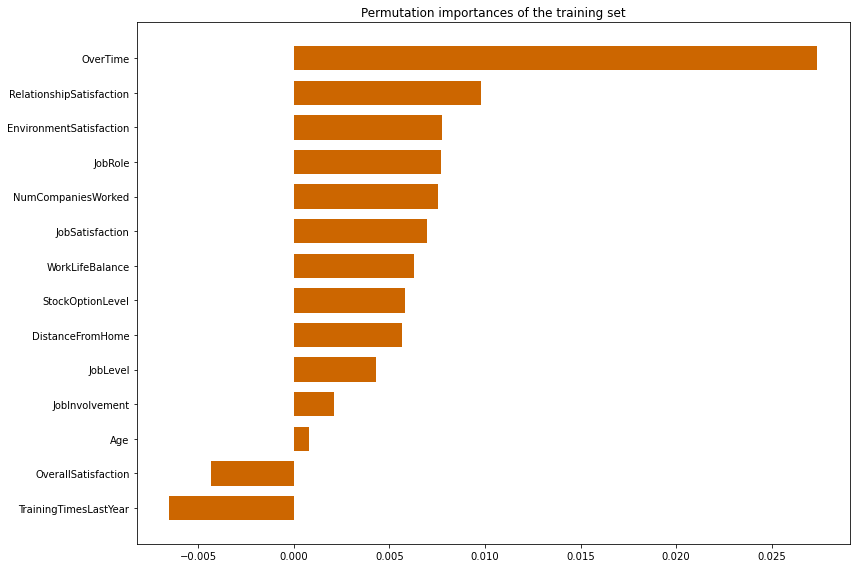



Predictions

Permutation importances of the test set

OverTime                                           0.043387
StockOptionLevel                                   0.035313
DistanceFromHome                                   0.016061
JobSatisfaction                                    0.015039
Age                                                0.012958
EnvironmentSatisfaction                            0.010105
WorkLifeBalance                                    0.005436
JobInvolvement                                     0.001301
JobRole                                            -0.002652
OverallSatisfaction                                -0.005262
JobLevel                                           -0.005749
RelationshipSatisfaction                           -0.008393
NumCompaniesWorked                                 -0.011887
TrainingTimesLastYear                              -0.027620



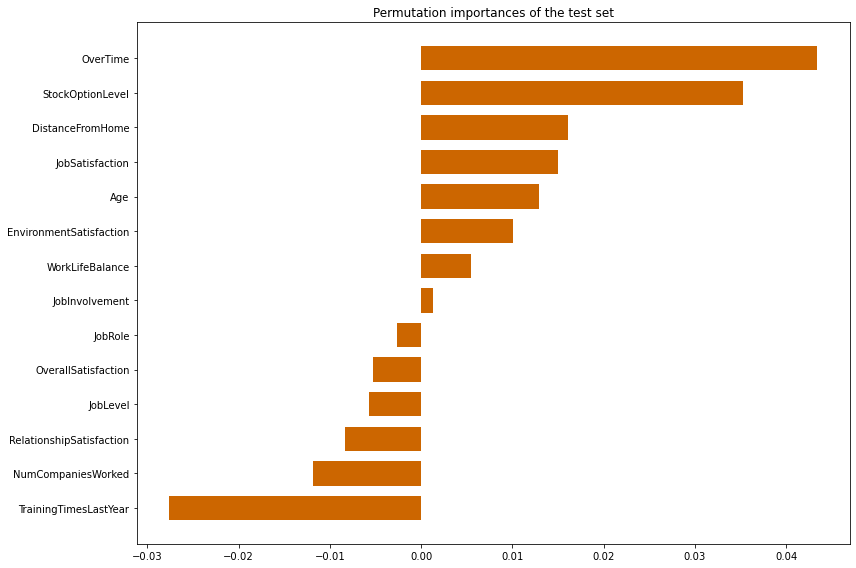



Confusion matrix


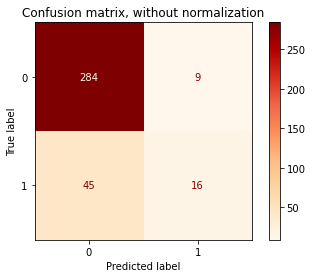

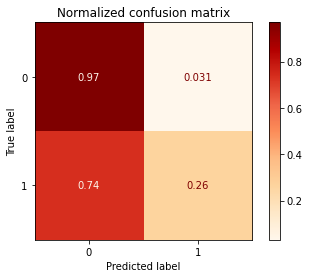


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       293
           1       0.64      0.26      0.37        61

    accuracy                           0.85       354
   macro avg       0.75      0.62      0.64       354
weighted avg       0.82      0.85      0.82       354


Metrics

Accuracy 0.847457627118644
F1-score [0.91318328 0.37209302]
Precision [0.86322188 0.64      ]
Recall [0.96928328 0.26229508]
Roc_auc 0.6157891792088626


Roc curve



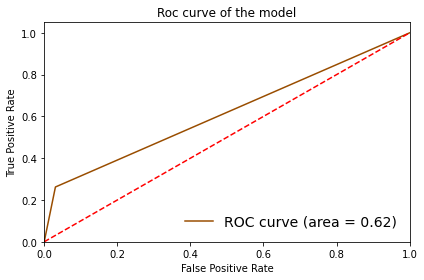


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5831204161128496
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


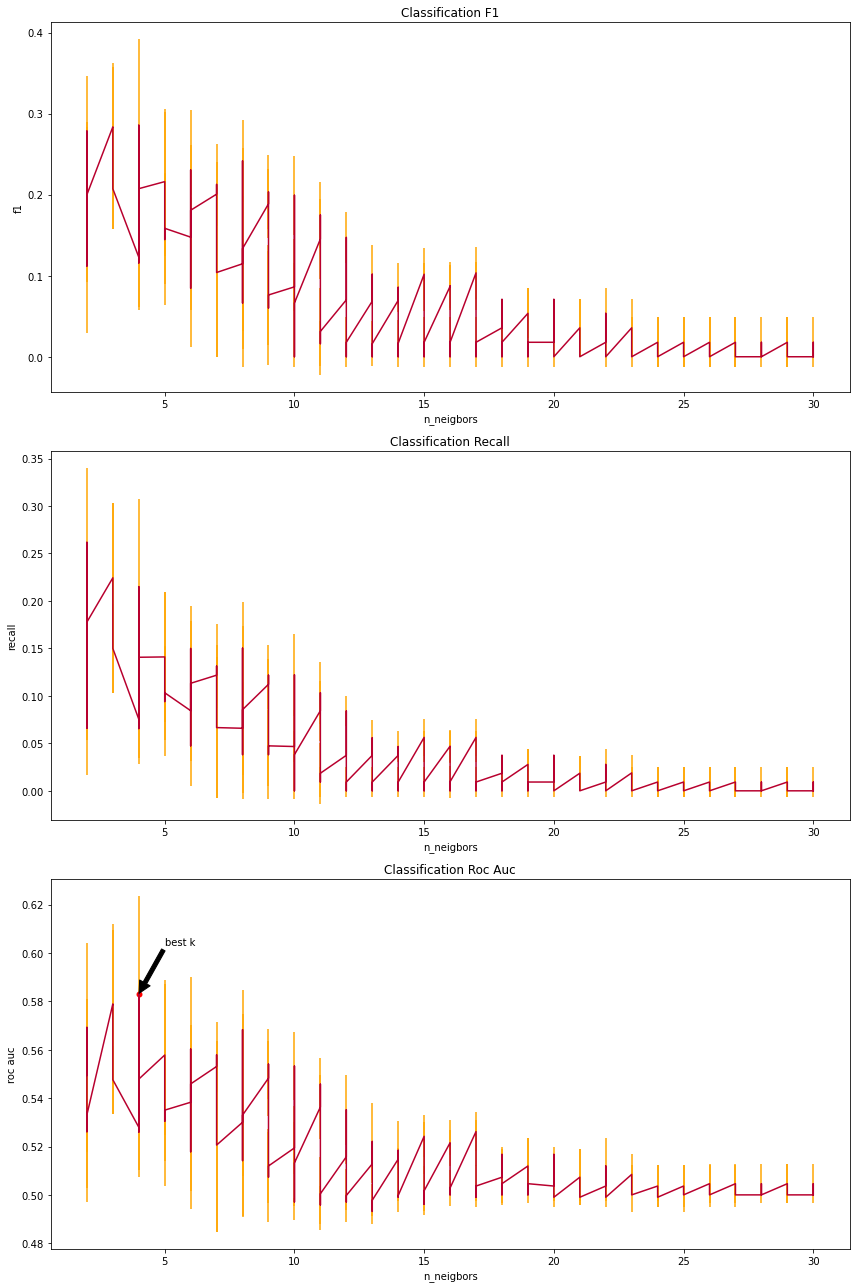



Permutation importances of the training set

OverTime                                           0.010917
NumCompaniesWorked                                 0.004228
RelationshipSatisfaction                           0.002293
DistanceFromHome                                   0.001898
Age                                                0.001706
EnvironmentSatisfaction                            0.001273
JobSatisfaction                                    0.001213
StockOptionLevel                                   0.000620
WorkLifeBalance                                    0.000134
JobInvolvement                                     0.000062
JobLevel                                           0.000007
JobRole                                            0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000



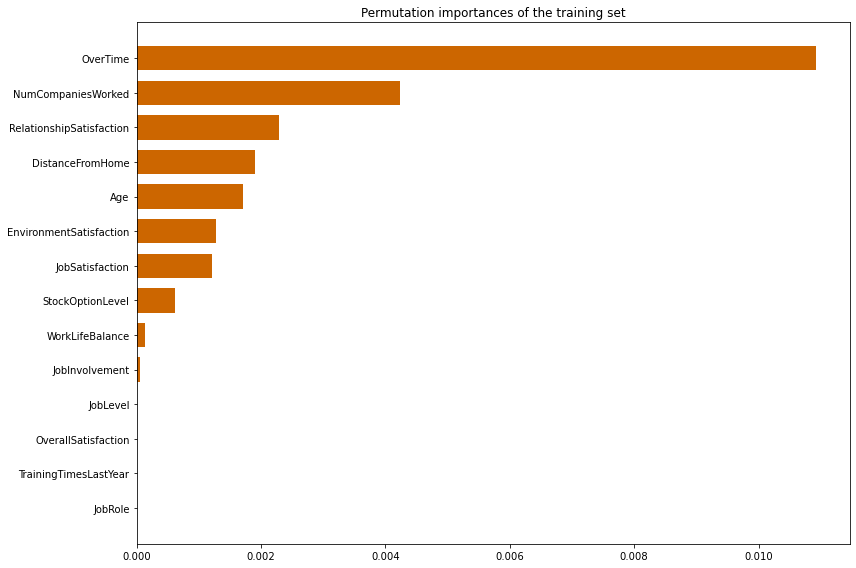



Predictions

Permutation importances of the test set

OverTime                                           0.089185
JobSatisfaction                                    0.061530
StockOptionLevel                                   0.048114
WorkLifeBalance                                    0.044734
RelationshipSatisfaction                           0.035760
Age                                                0.028921
JobInvolvement                                     0.027665
DistanceFromHome                                   0.019516
OverallSatisfaction                                0.011649
EnvironmentSatisfaction                            0.010765
JobLevel                                           0.005648
NumCompaniesWorked                                 0.003583
JobRole                                            -0.000313
TrainingTimesLastYear                              -0.009966



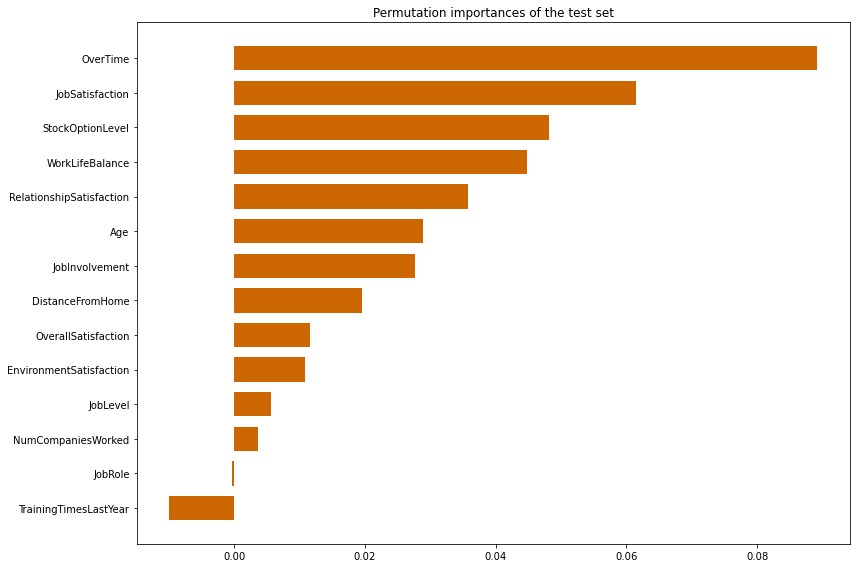



Confusion matrix


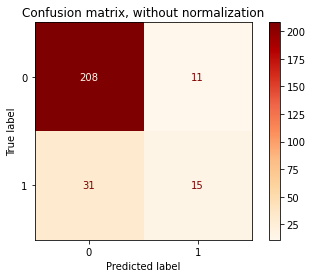

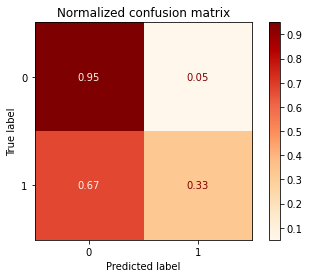


Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       219
           1       0.58      0.33      0.42        46

    accuracy                           0.84       265
   macro avg       0.72      0.64      0.66       265
weighted avg       0.82      0.84      0.82       265


Metrics

Accuracy 0.8415094339622642
F1-score [0.90829694 0.41666667]
Precision [0.87029289 0.57692308]
Recall [0.94977169 0.32608696]
Roc_auc 0.637929323009728


Roc curve



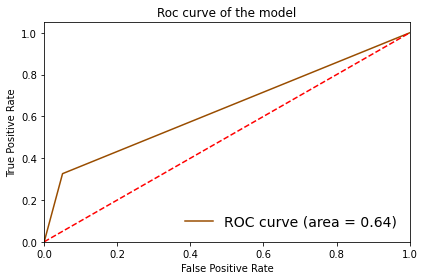


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6402470908823097
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


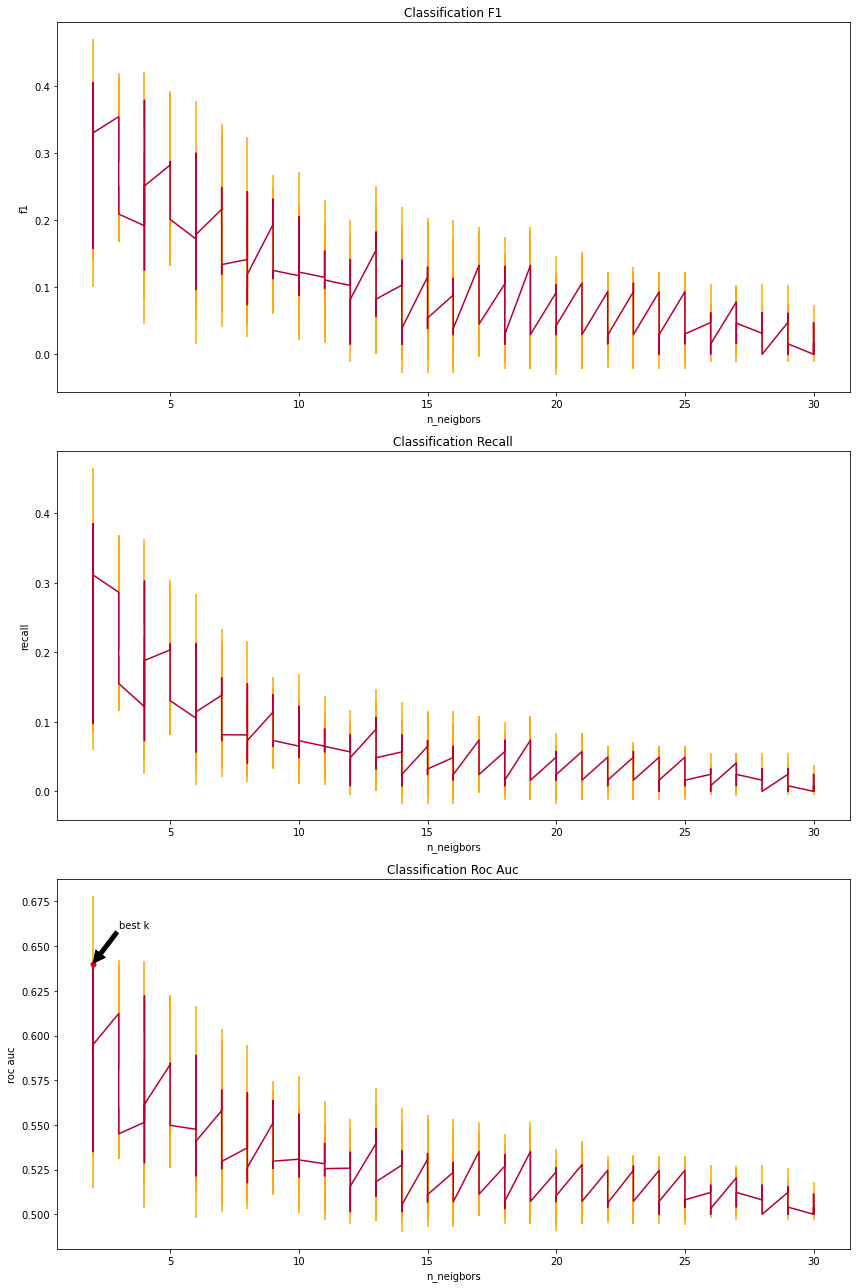



Permutation importances of the training set

OverTime                                           0.007802
JobSatisfaction                                    0.001467
StockOptionLevel                                   0.000500
EnvironmentSatisfaction                            0.000449
NumCompaniesWorked                                 0.000290
RelationshipSatisfaction                           0.000108
DistanceFromHome                                   0.000070
Age                                                0.000034
JobInvolvement                                     0.000013
JobRole                                            0.000000
OverallSatisfaction                                0.000000
JobLevel                                           0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



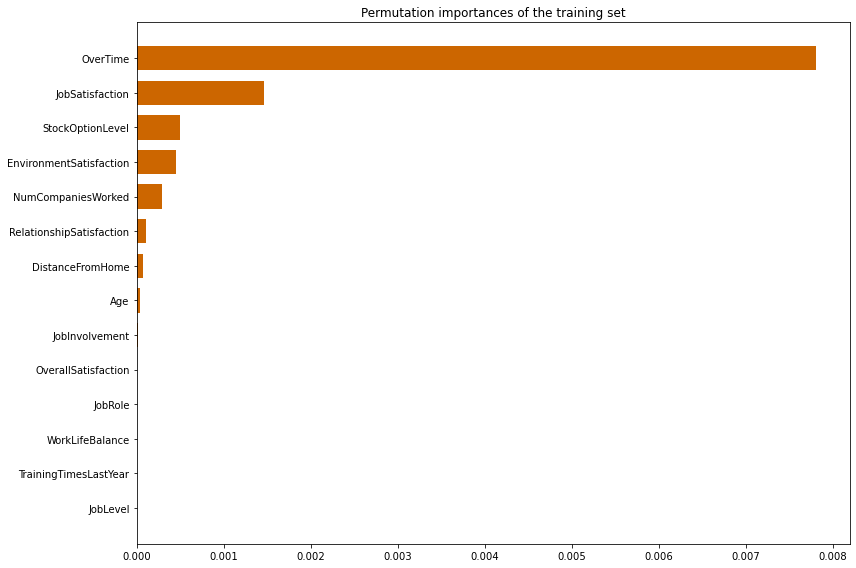



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.057258
JobSatisfaction                                    0.039041
OverTime                                           0.030457
Age                                                0.027375
DistanceFromHome                                   0.011279
NumCompaniesWorked                                 0.010771
WorkLifeBalance                                    0.009125
JobLevel                                           0.005513
RelationshipSatisfaction                           -0.005457
JobRole                                            -0.009887
TrainingTimesLastYear                              -0.017620
OverallSatisfaction                                -0.030932
JobInvolvement                                     -0.030977
EnvironmentSatisfaction                            -0.031396



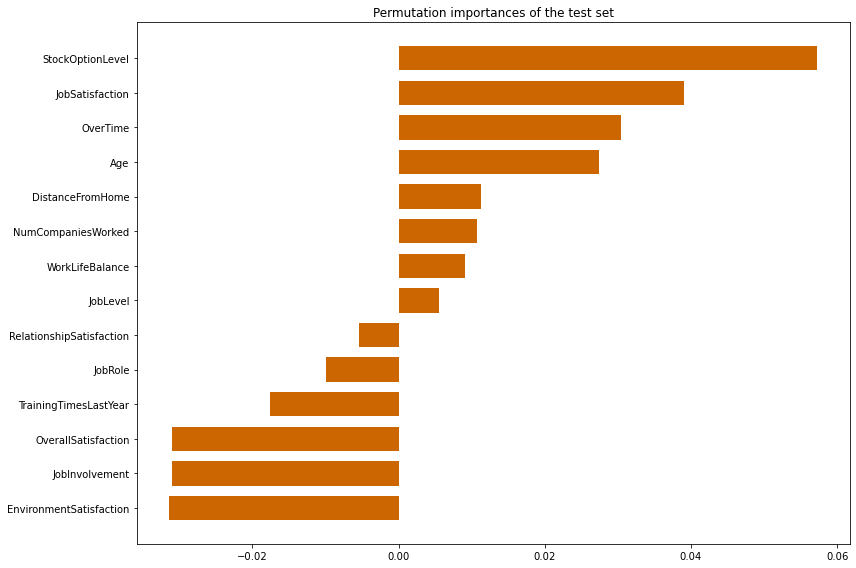



Confusion matrix


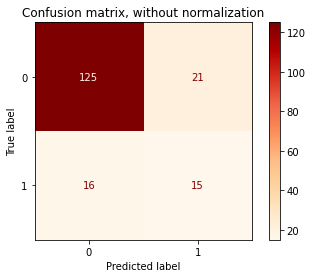

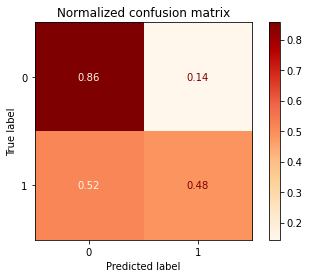


Classification report
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       146
           1       0.42      0.48      0.45        31

    accuracy                           0.79       177
   macro avg       0.65      0.67      0.66       177
weighted avg       0.80      0.79      0.80       177


Metrics

Accuracy 0.7909604519774012
F1-score [0.87108014 0.44776119]
Precision [0.88652482 0.41666667]
Recall [0.85616438 0.48387097]
Roc_auc 0.6700176756517897


Roc curve



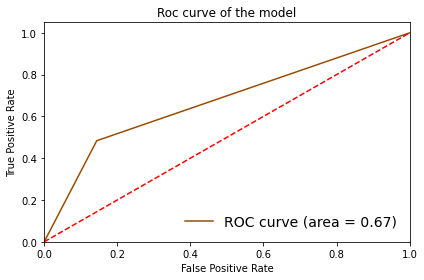


-------------------------------------------------------------------------------------------------------------



In [72]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6124315552815752
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


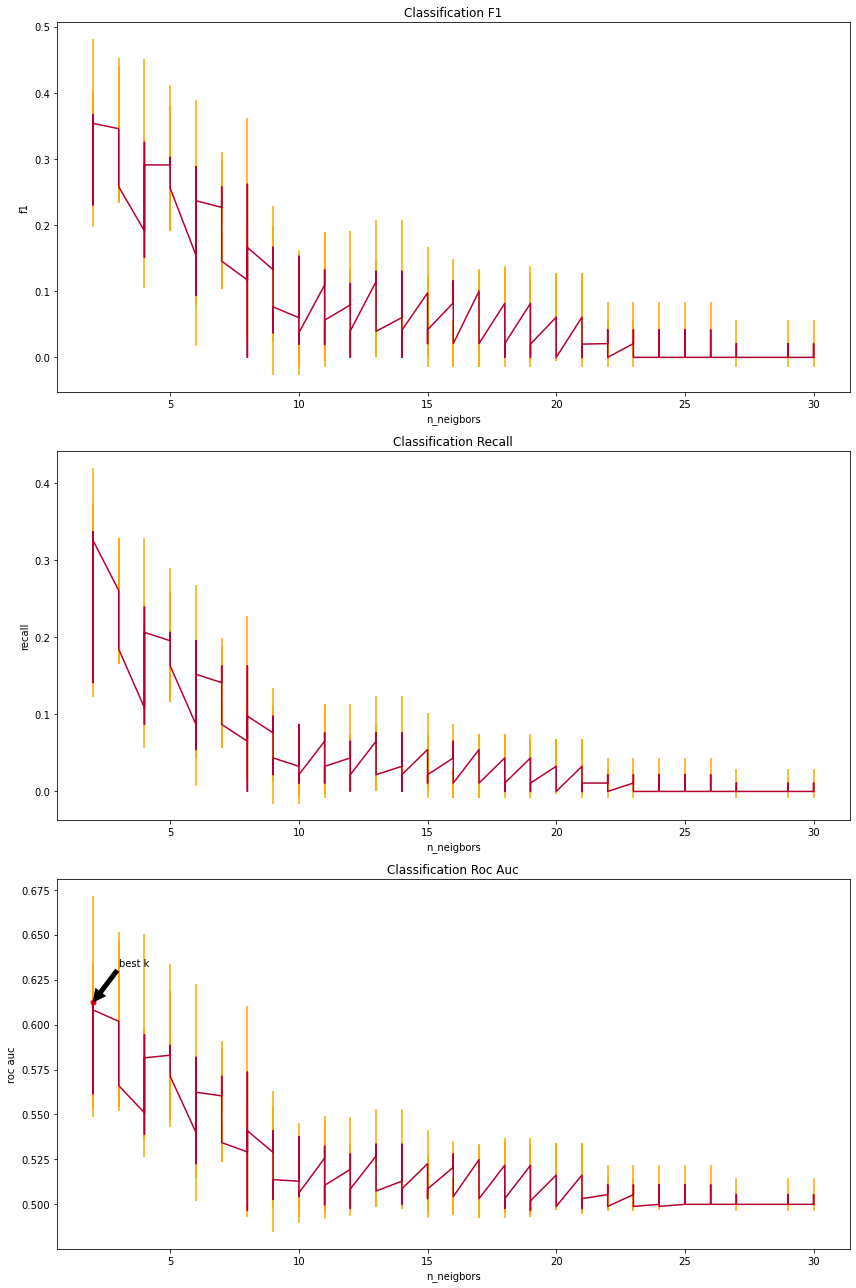



Permutation importances of the training set

OverTime                                           0.015374
NumCompaniesWorked                                 0.010393
StockOptionLevel                                   0.000174
Age                                                0.000078
DistanceFromHome                                   0.000065
JobSatisfaction                                    0.000036
RelationshipSatisfaction                           0.000019
JobInvolvement                                     0.000001
EnvironmentSatisfaction                            0.000001
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
TrainingTimesLastYear                              0.000000
WorkLifeBalance                                    0.000000



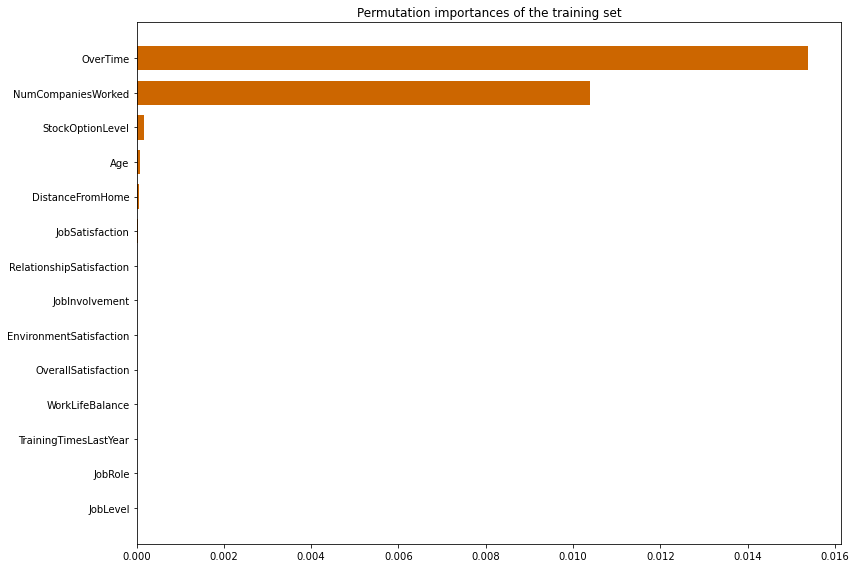



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.060158
OverTime                                           0.033542
JobInvolvement                                     0.026330
JobSatisfaction                                    0.019443
RelationshipSatisfaction                           0.017163
WorkLifeBalance                                    0.016033
Age                                                0.013616
EnvironmentSatisfaction                            0.010323
JobLevel                                           0.007587
DistanceFromHome                                   0.005578
OverallSatisfaction                                0.002311
JobRole                                            -0.004820
NumCompaniesWorked                                 -0.007872
TrainingTimesLastYear                              -0.010891



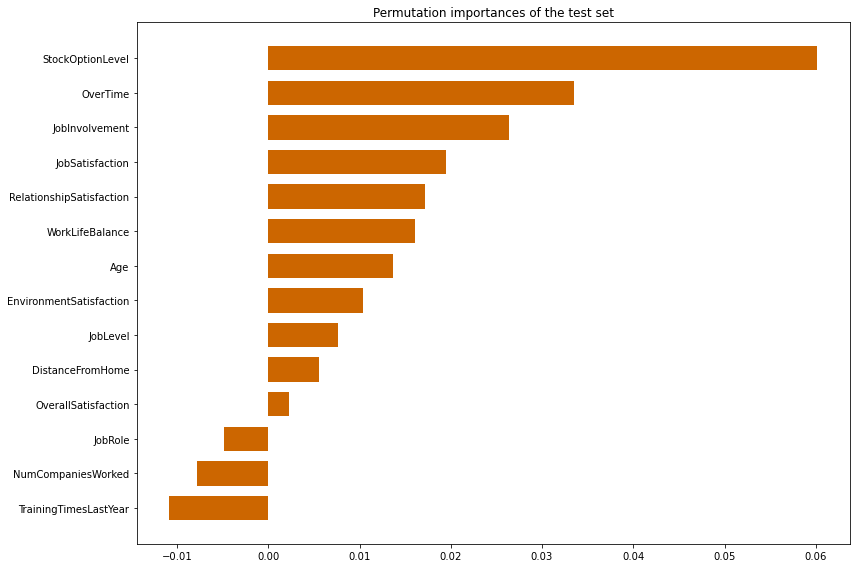



Confusion matrix


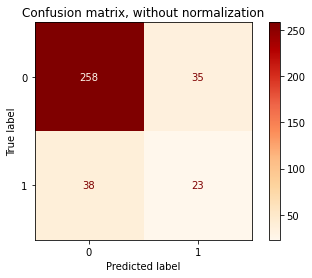

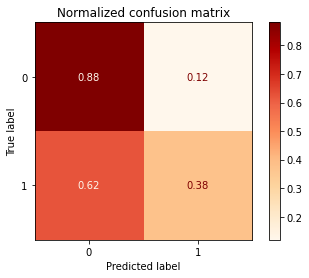


Classification report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       293
           1       0.40      0.38      0.39        61

    accuracy                           0.79       354
   macro avg       0.63      0.63      0.63       354
weighted avg       0.79      0.79      0.79       354


Metrics

Accuracy 0.7937853107344632
F1-score [0.87606112 0.38655462]
Precision [0.87162162 0.39655172]
Recall [0.88054608 0.37704918]
Roc_auc 0.6287976277065965


Roc curve



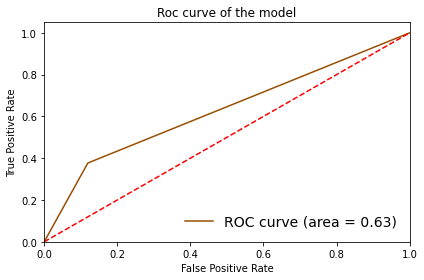


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5886437985816676
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


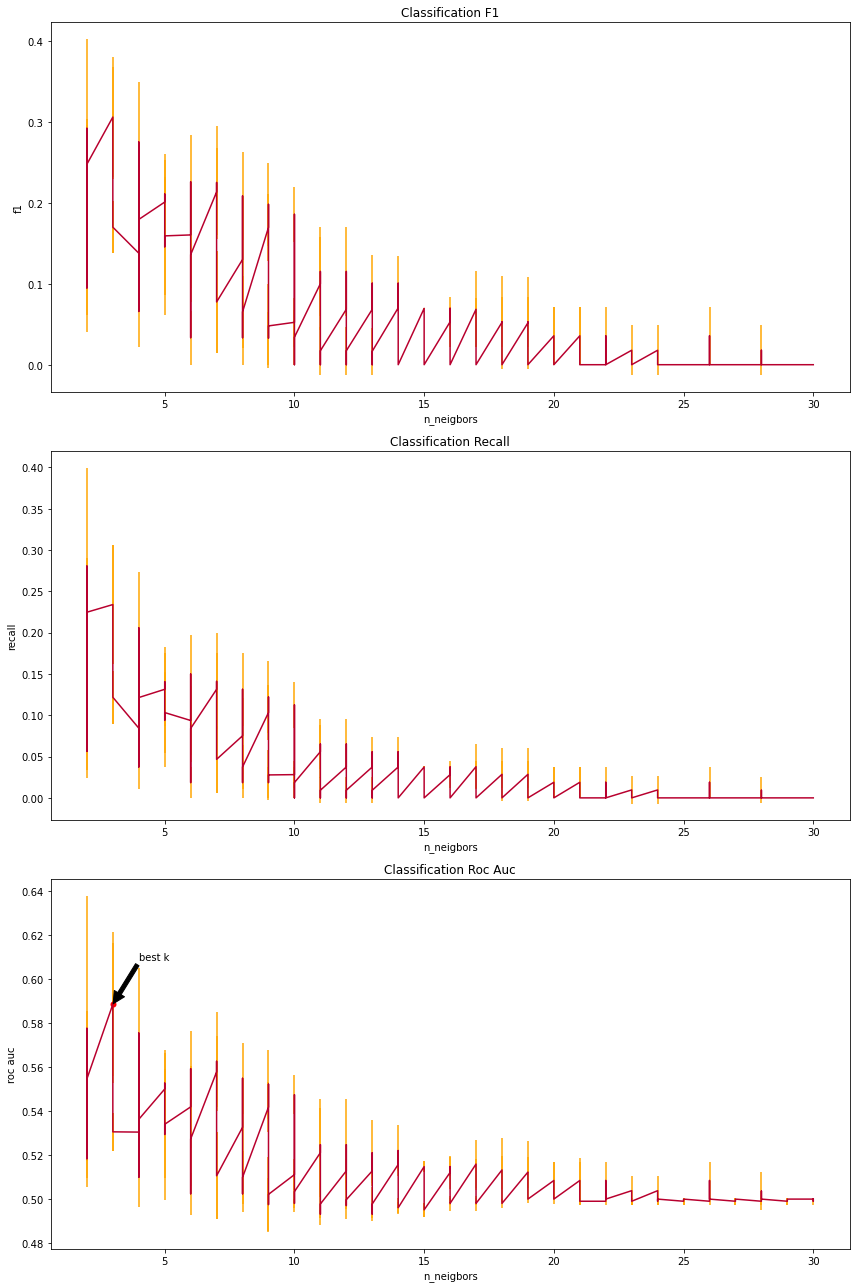



Permutation importances of the training set

OverTime                                           0.024041
EnvironmentSatisfaction                            0.013733
JobRole                                            0.012022
NumCompaniesWorked                                 0.010188
StockOptionLevel                                   0.010122
RelationshipSatisfaction                           0.010065
JobSatisfaction                                    0.009614
WorkLifeBalance                                    0.009422
JobLevel                                           0.009403
DistanceFromHome                                   0.007666
JobInvolvement                                     0.006991
Age                                                0.005537
OverallSatisfaction                                0.003557
TrainingTimesLastYear                              -0.001399



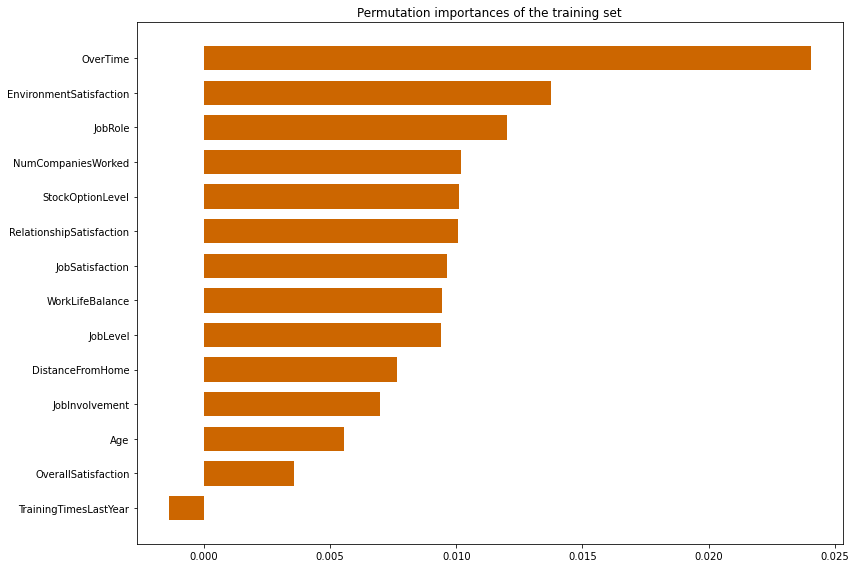



Predictions

Permutation importances of the test set

OverTime                                           0.044570
StockOptionLevel                                   0.039691
JobSatisfaction                                    0.020335
JobInvolvement                                     0.013019
DistanceFromHome                                   0.006978
OverallSatisfaction                                -0.002784
RelationshipSatisfaction                           -0.007013
Age                                                -0.008120
JobLevel                                           -0.008170
WorkLifeBalance                                    -0.021774
NumCompaniesWorked                                 -0.024459
JobRole                                            -0.026633
TrainingTimesLastYear                              -0.033284
EnvironmentSatisfaction                            -0.039562



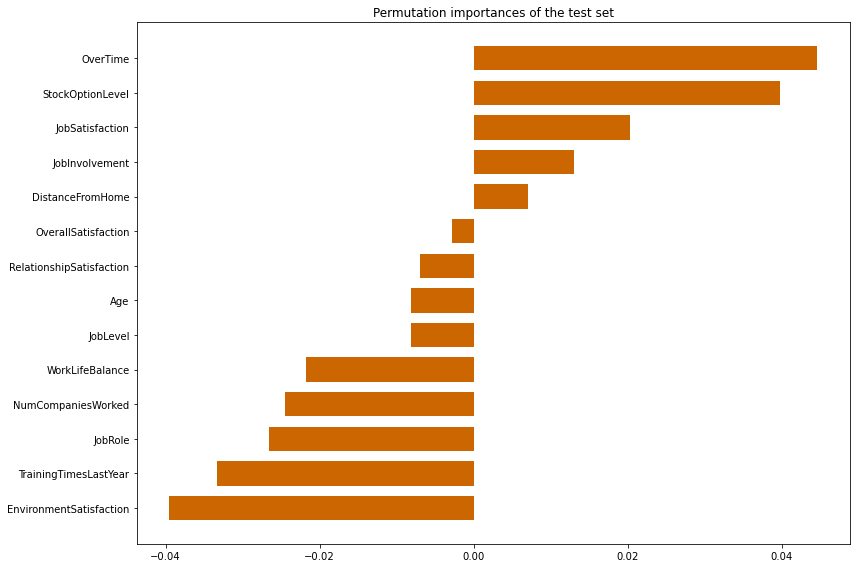



Confusion matrix


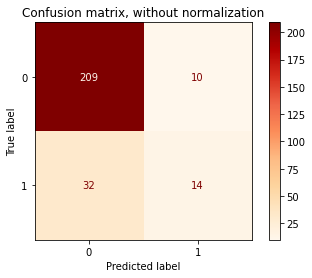

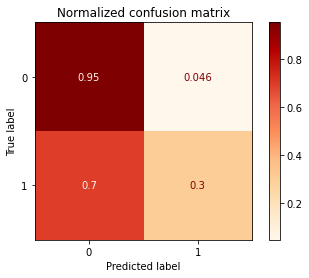


Classification report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       219
           1       0.58      0.30      0.40        46

    accuracy                           0.84       265
   macro avg       0.73      0.63      0.65       265
weighted avg       0.82      0.84      0.82       265


Metrics

Accuracy 0.8415094339622642
F1-score [0.90869565 0.4       ]
Precision [0.86721992 0.58333333]
Recall [0.9543379  0.30434783]
Roc_auc 0.6293428628151677


Roc curve



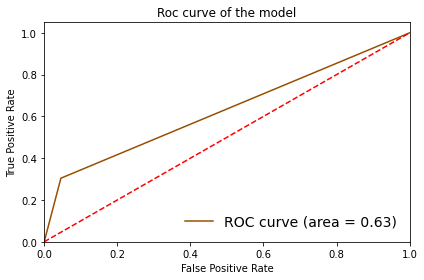


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6386691707173369
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


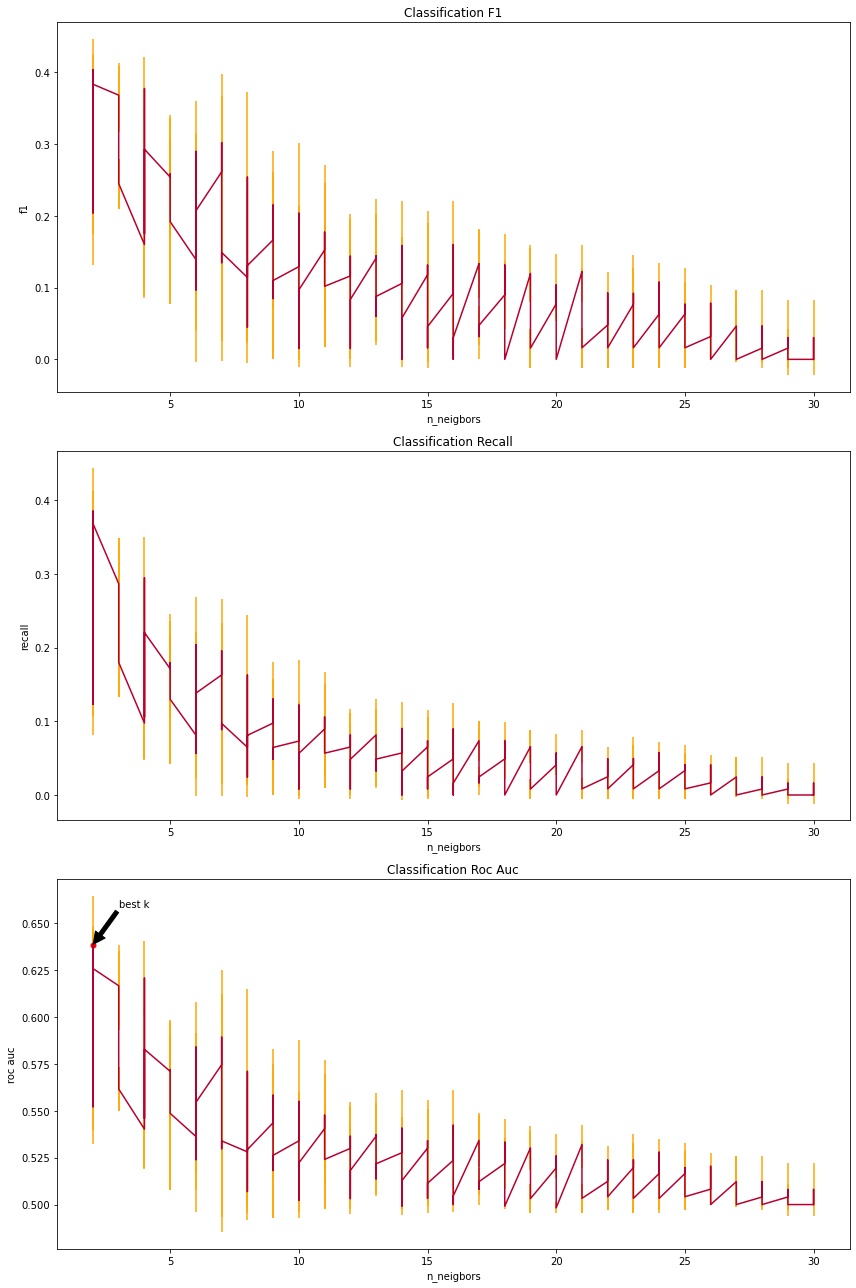



Permutation importances of the training set

OverTime                                           0.019668
NumCompaniesWorked                                 0.012049
StockOptionLevel                                   0.000521
DistanceFromHome                                   0.000408
Age                                                0.000339
EnvironmentSatisfaction                            0.000338
JobSatisfaction                                    0.000051
RelationshipSatisfaction                           0.000008
TrainingTimesLastYear                              0.000007
JobInvolvement                                     0.000001
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
WorkLifeBalance                                    0.000000



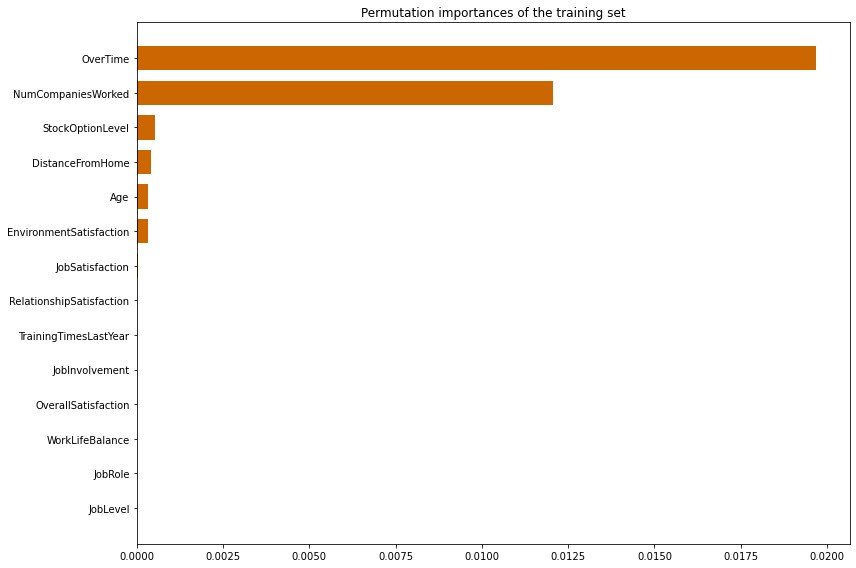



Predictions

Permutation importances of the test set

OverTime                                           0.058926
StockOptionLevel                                   0.057380
Age                                                0.051392
JobSatisfaction                                    0.050265
JobLevel                                           0.022139
WorkLifeBalance                                    0.017156
DistanceFromHome                                   0.010429
NumCompaniesWorked                                 0.009412
EnvironmentSatisfaction                            0.006231
JobInvolvement                                     0.000354
OverallSatisfaction                                0.000122
JobRole                                            -0.001922
RelationshipSatisfaction                           -0.013345
TrainingTimesLastYear                              -0.021940



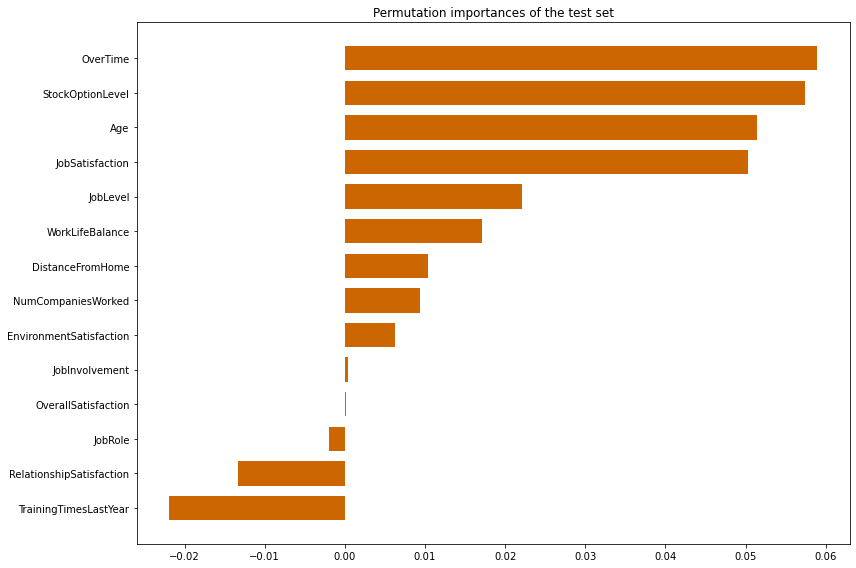



Confusion matrix


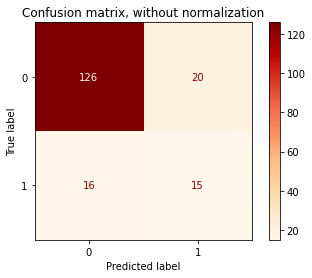

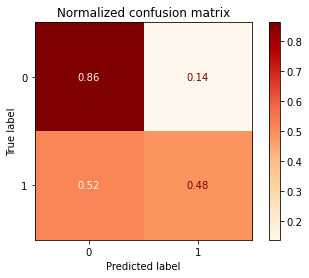


Classification report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       146
           1       0.43      0.48      0.45        31

    accuracy                           0.80       177
   macro avg       0.66      0.67      0.66       177
weighted avg       0.81      0.80      0.80       177


Metrics

Accuracy 0.7966101694915254
F1-score [0.875      0.45454545]
Precision [0.88732394 0.42857143]
Recall [0.8630137  0.48387097]
Roc_auc 0.6734423331860362


Roc curve



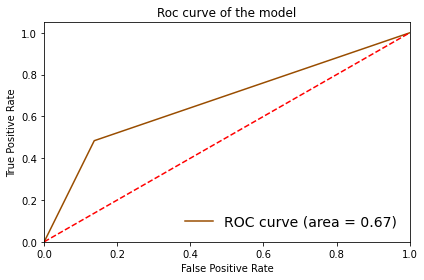


-------------------------------------------------------------------------------------------------------------



In [73]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6070026652645321
Best parameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

Best k ('n_neighbors'): 6

Plots of the metrics used by the grid search


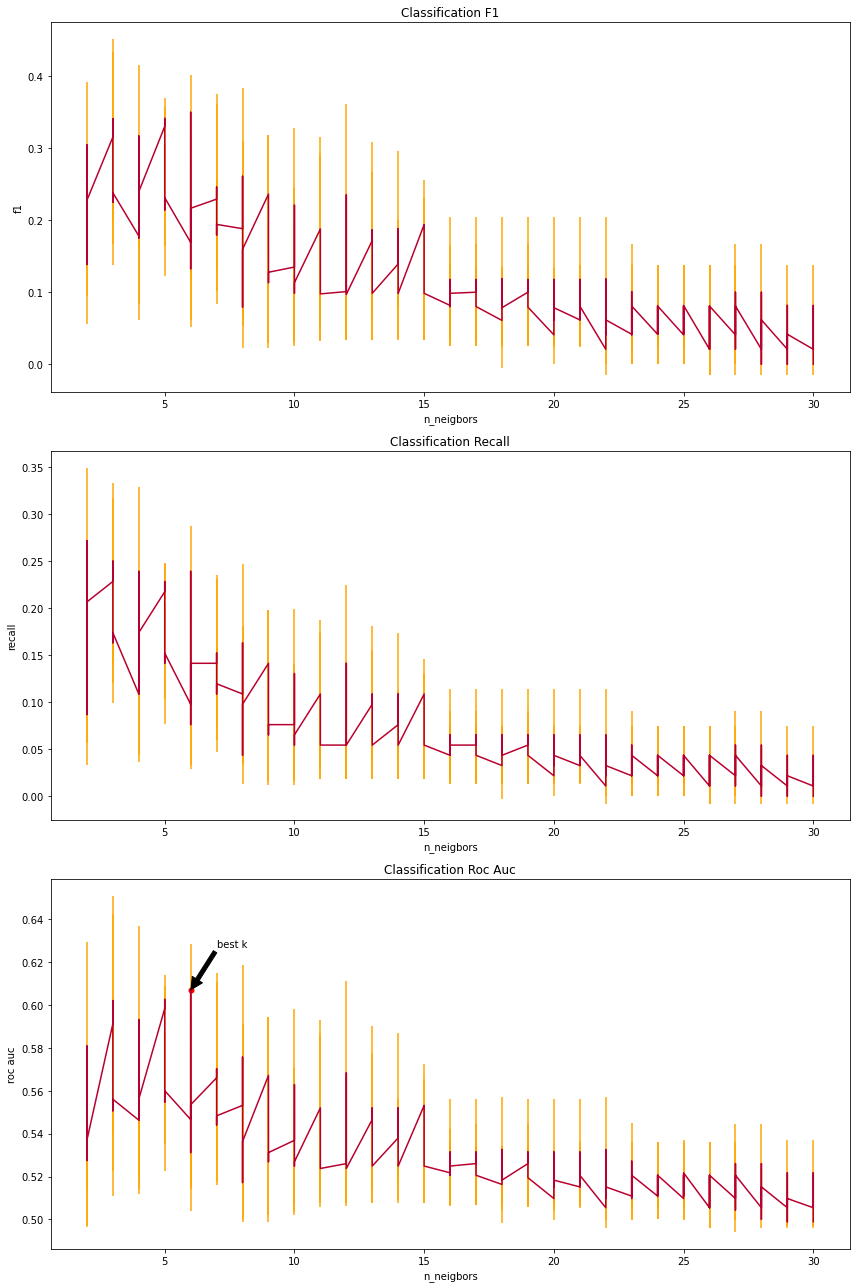



Permutation importances of the training set

TrainingTimesLastYear                              0.004599
StockOptionLevel                                   0.004174
JobRole                                            0.002870
JobLevel                                           0.002689
WorkLifeBalance                                    0.001433
JobInvolvement                                     0.000885
NumCompaniesWorked                                 0.000801
OverallSatisfaction                                0.000649
DistanceFromHome                                   0.000468
RelationshipSatisfaction                           0.000398
OverTime                                           0.000301
JobSatisfaction                                    0.000241
Age                                                0.000162
EnvironmentSatisfaction                            0.000147



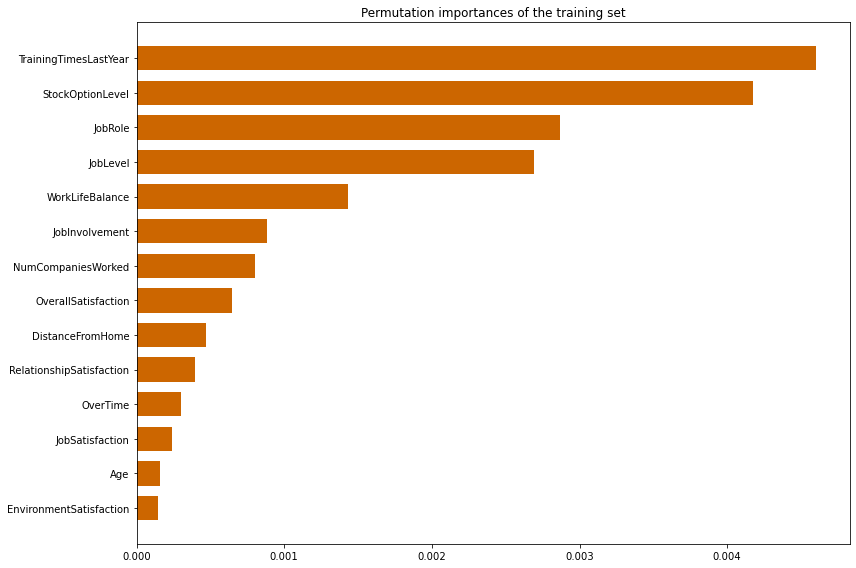



Predictions

Permutation importances of the test set

OverTime                                           0.024022
StockOptionLevel                                   0.014298
JobLevel                                           0.005855
OverallSatisfaction                                -0.003251
JobRole                                            -0.006339
DistanceFromHome                                   -0.007839
RelationshipSatisfaction                           -0.008342
WorkLifeBalance                                    -0.008835
EnvironmentSatisfaction                            -0.015417
JobSatisfaction                                    -0.022442
Age                                                -0.023021
JobInvolvement                                     -0.024045
NumCompaniesWorked                                 -0.031878
TrainingTimesLastYear                              -0.058625



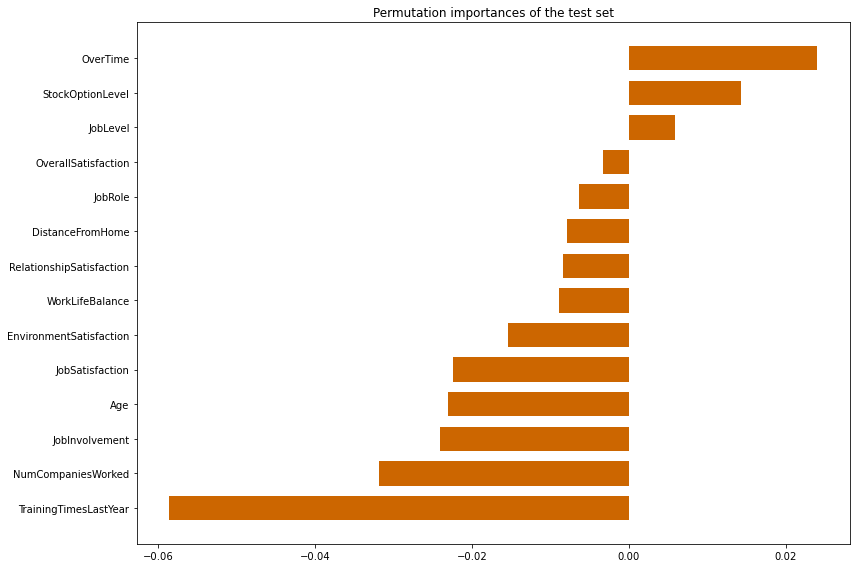



Confusion matrix


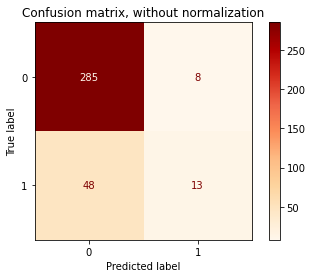

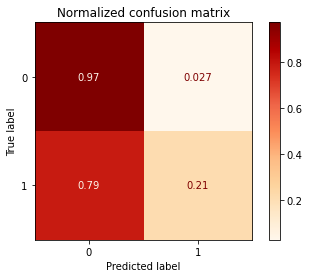


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       293
           1       0.62      0.21      0.32        61

    accuracy                           0.84       354
   macro avg       0.74      0.59      0.61       354
weighted avg       0.82      0.84      0.81       354


Metrics

Accuracy 0.8418079096045198
F1-score [0.91054313 0.31707317]
Precision [0.85585586 0.61904762]
Recall [0.97269625 0.21311475]
Roc_auc 0.5929054999160746


Roc curve



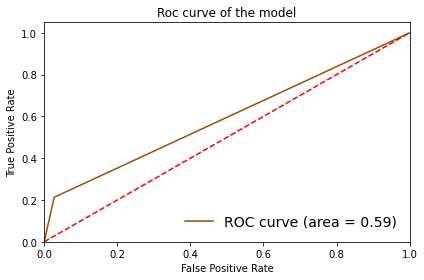


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5852237814974651
Best parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(p=1)

Best k ('n_neighbors'): 5

Plots of the metrics used by the grid search


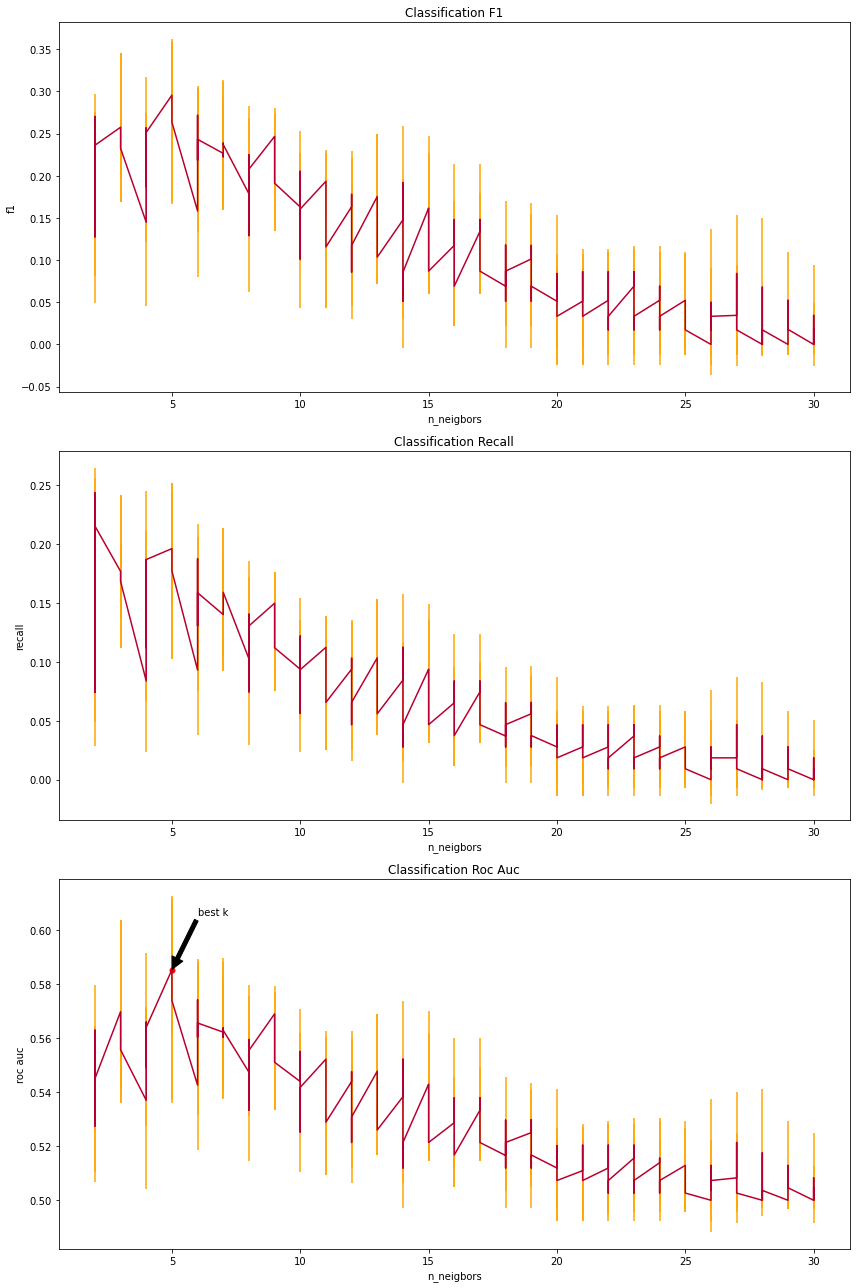



Permutation importances of the training set

StockOptionLevel                                   0.015756
OverTime                                           0.013540
JobRole                                            0.012602
WorkLifeBalance                                    0.006960
JobLevel                                           0.002197
NumCompaniesWorked                                 -0.002093
JobSatisfaction                                    -0.002349
RelationshipSatisfaction                           -0.003704
OverallSatisfaction                                -0.006521
Age                                                -0.007839
EnvironmentSatisfaction                            -0.009682
DistanceFromHome                                   -0.012033
JobInvolvement                                     -0.012576
TrainingTimesLastYear                              -0.018253



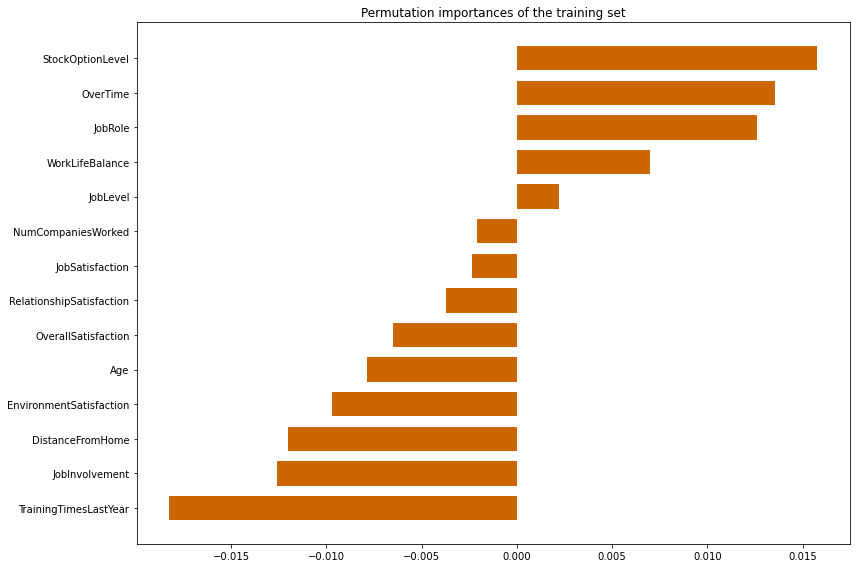



Predictions

Permutation importances of the test set

OverTime                                           0.033611
StockOptionLevel                                   0.026196
JobRole                                            0.000601
JobLevel                                           0.000313
JobInvolvement                                     -0.001777
OverallSatisfaction                                -0.003847
WorkLifeBalance                                    -0.007460
NumCompaniesWorked                                 -0.008021
EnvironmentSatisfaction                            -0.012716
DistanceFromHome                                   -0.013957
RelationshipSatisfaction                           -0.019223
JobSatisfaction                                    -0.020106
Age                                                -0.031820
TrainingTimesLastYear                              -0.048829



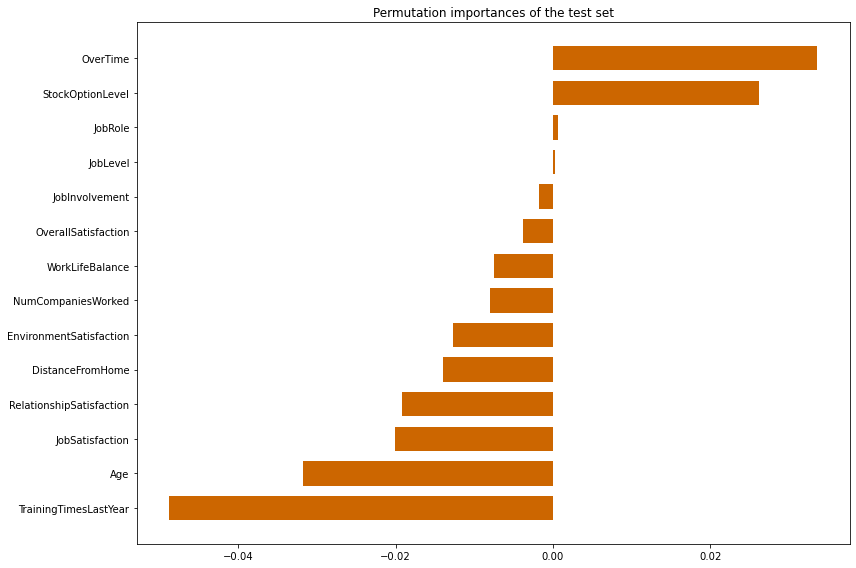



Confusion matrix


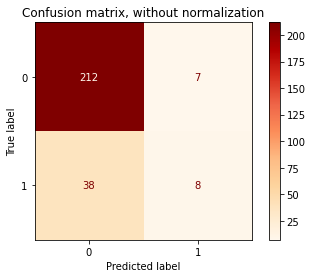

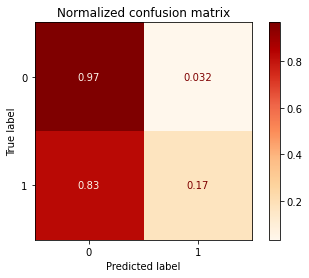


Classification report
              precision    recall  f1-score   support

           0       0.85      0.97      0.90       219
           1       0.53      0.17      0.26        46

    accuracy                           0.83       265
   macro avg       0.69      0.57      0.58       265
weighted avg       0.79      0.83      0.79       265


Metrics

Accuracy 0.8301886792452831
F1-score [0.90405117 0.26229508]
Precision [0.848      0.53333333]
Recall [0.96803653 0.17391304]
Roc_auc 0.570974786579313


Roc curve



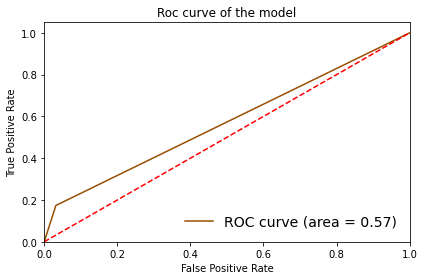


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6198943143320077
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


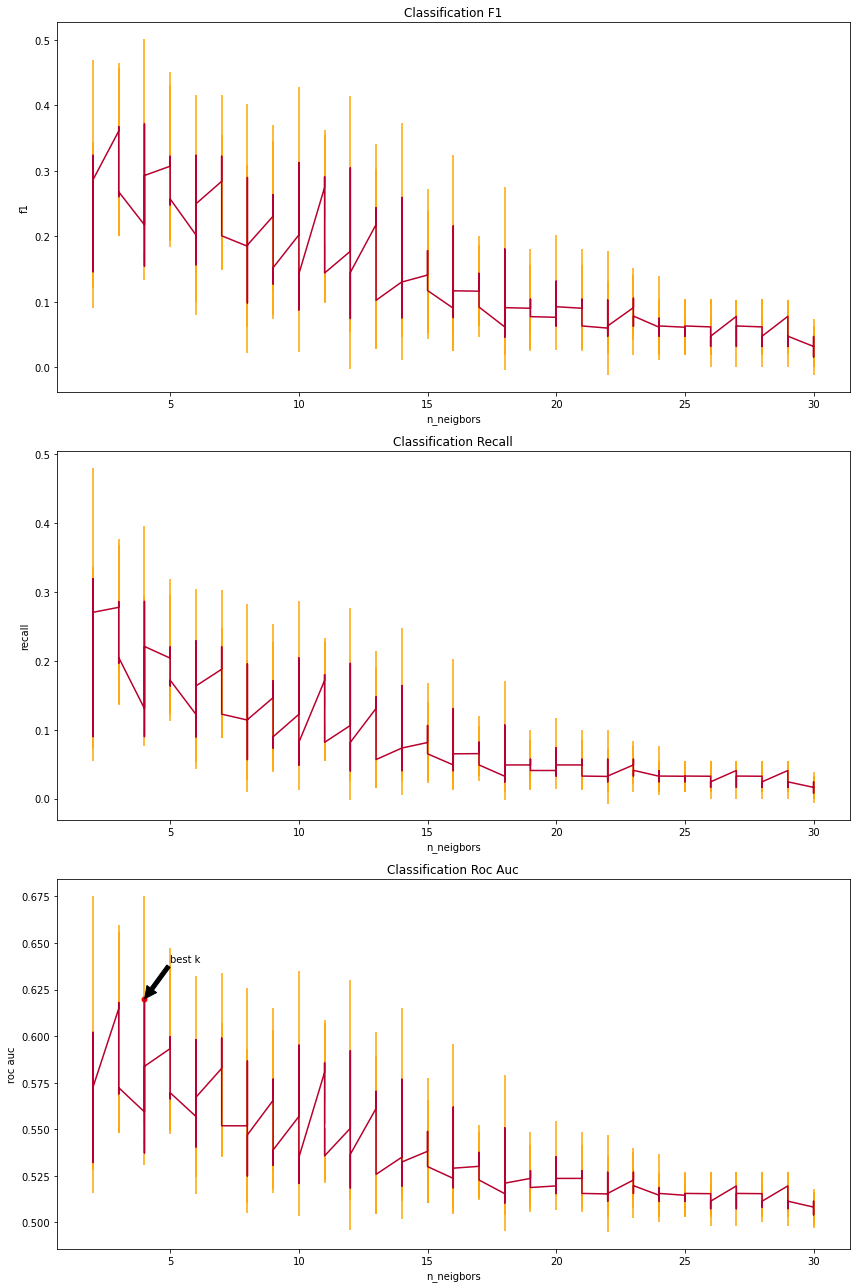



Permutation importances of the training set

StockOptionLevel                                   0.004009
TrainingTimesLastYear                              0.002325
JobLevel                                           0.001127
WorkLifeBalance                                    0.000765
JobRole                                            0.000641
JobInvolvement                                     0.000507
NumCompaniesWorked                                 0.000505
Age                                                0.000400
DistanceFromHome                                   0.000341
OverTime                                           0.000185
JobSatisfaction                                    0.000122
RelationshipSatisfaction                           0.000095
EnvironmentSatisfaction                            0.000073
OverallSatisfaction                                0.000031



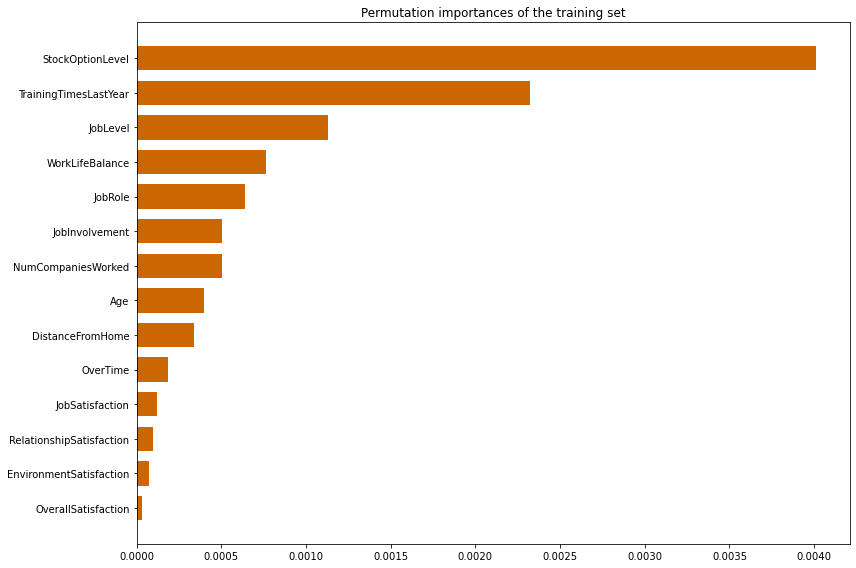



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.058020
WorkLifeBalance                                    0.004419
OverTime                                           -0.000044
NumCompaniesWorked                                 -0.003646
JobSatisfaction                                    -0.004209
EnvironmentSatisfaction                            -0.004518
OverallSatisfaction                                -0.005502
DistanceFromHome                                   -0.011080
JobLevel                                           -0.012715
JobRole                                            -0.014141
RelationshipSatisfaction                           -0.014439
JobInvolvement                                     -0.019830
TrainingTimesLastYear                              -0.033330
Age                                                -0.035716



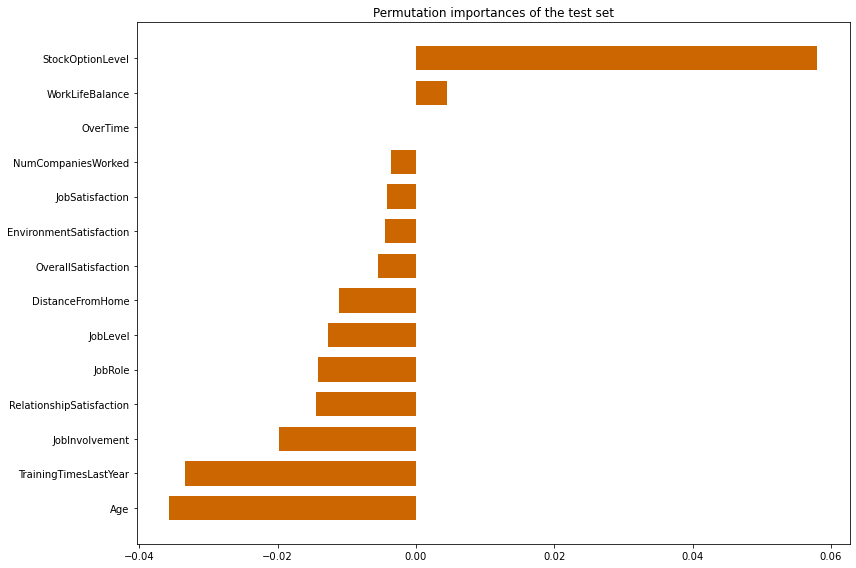



Confusion matrix


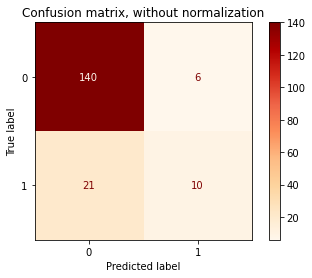

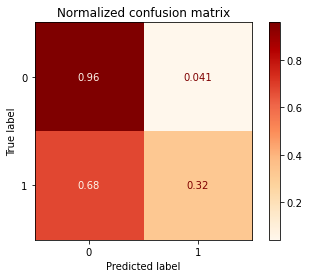


Classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       146
           1       0.62      0.32      0.43        31

    accuracy                           0.85       177
   macro avg       0.75      0.64      0.67       177
weighted avg       0.83      0.85      0.83       177


Metrics

Accuracy 0.847457627118644
F1-score [0.91205212 0.42553191]
Precision [0.86956522 0.625     ]
Recall [0.95890411 0.32258065]
Roc_auc 0.6407423773751657


Roc curve



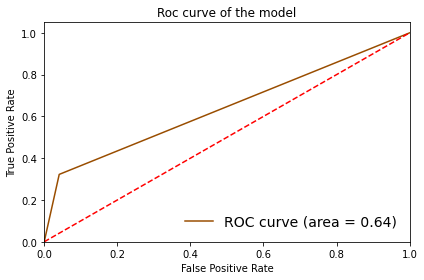


-------------------------------------------------------------------------------------------------------------



In [74]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6024259346556913
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1)

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


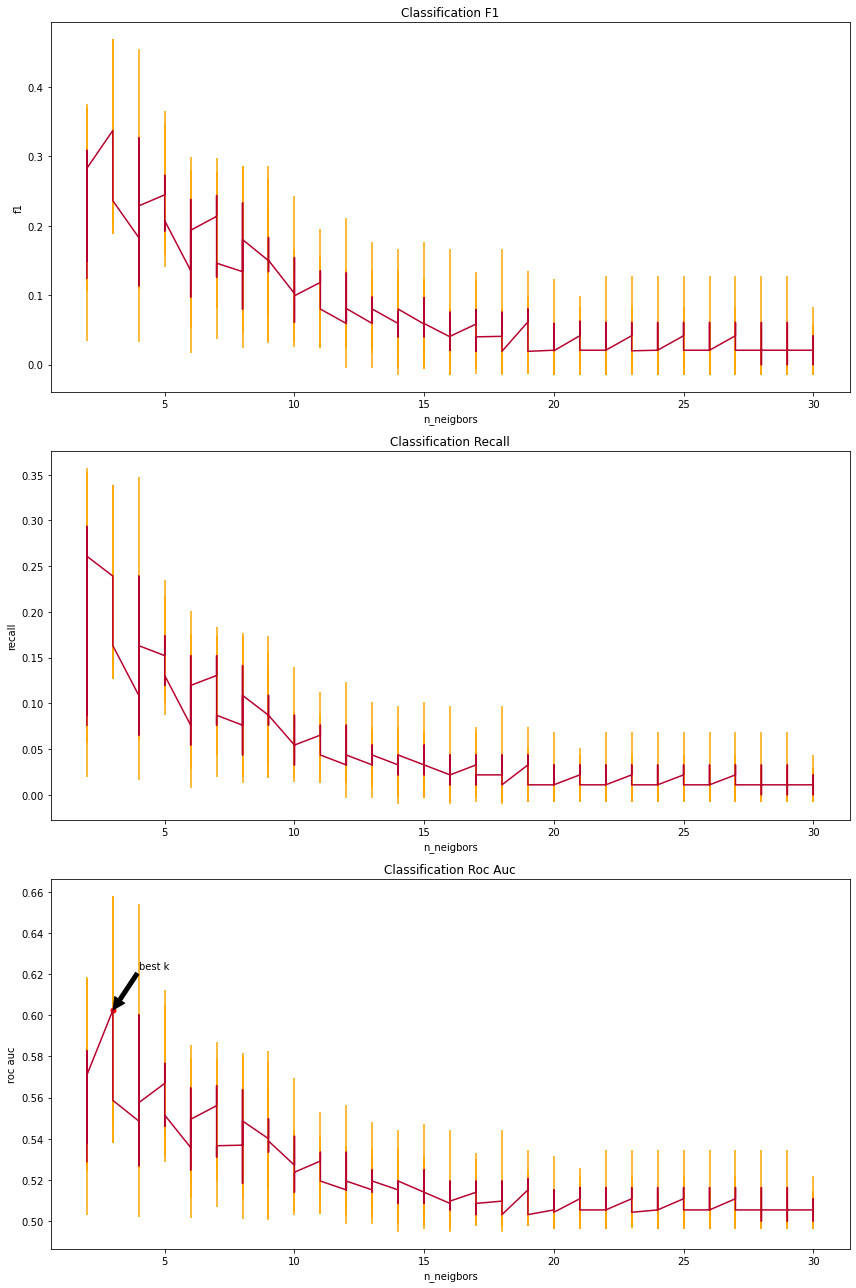



Permutation importances of the training set

OverTime                                           0.021793
StockOptionLevel                                   0.010407
JobLevel                                           0.000663
JobSatisfaction                                    0.000327
JobRole                                            0.000070
NumCompaniesWorked                                 -0.000817
WorkLifeBalance                                    -0.001885
RelationshipSatisfaction                           -0.004031
JobInvolvement                                     -0.004465
DistanceFromHome                                   -0.005858
EnvironmentSatisfaction                            -0.006101
Age                                                -0.006221
TrainingTimesLastYear                              -0.009207
OverallSatisfaction                                -0.010112



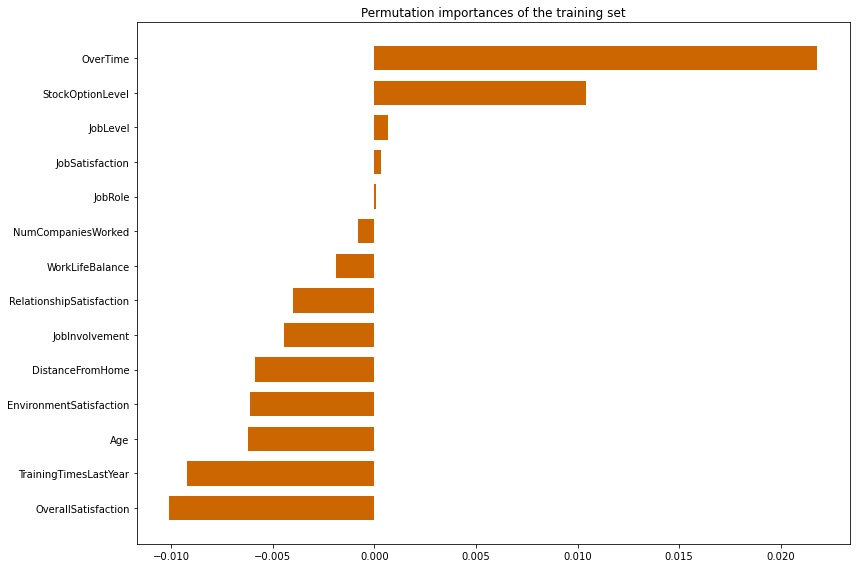



Predictions

Permutation importances of the test set

OverTime                                           0.033414
StockOptionLevel                                   0.028921
Age                                                0.026263
JobInvolvement                                     0.019974
EnvironmentSatisfaction                            0.017373
DistanceFromHome                                   0.016637
RelationshipSatisfaction                           0.016270
OverallSatisfaction                                0.015560
JobRole                                            0.014094
JobSatisfaction                                    0.011982
JobLevel                                           0.010625
NumCompaniesWorked                                 0.005741
WorkLifeBalance                                    -0.000909
TrainingTimesLastYear                              -0.020276



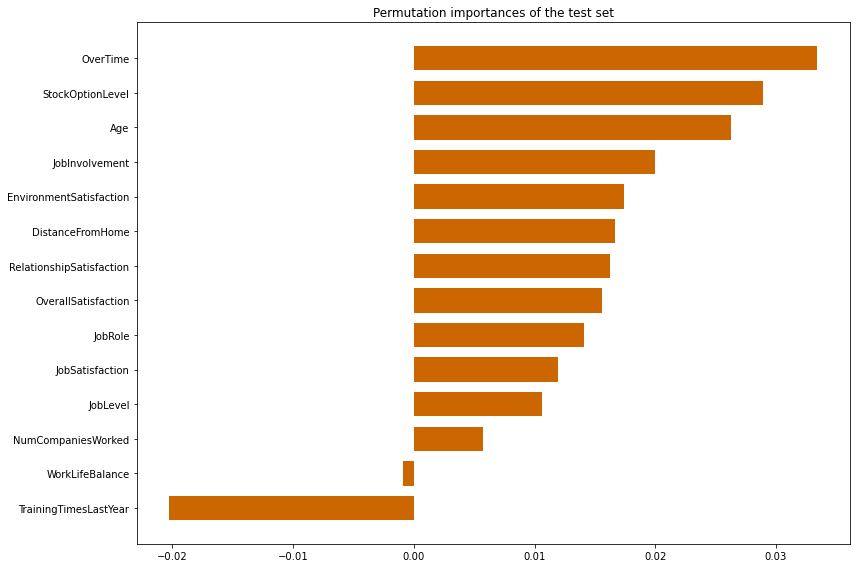



Confusion matrix


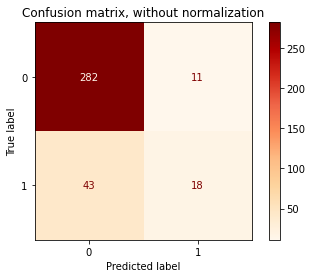

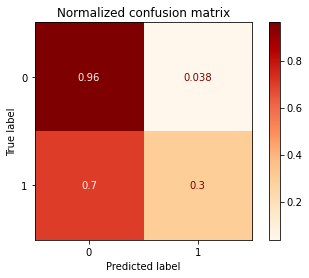


Classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       293
           1       0.62      0.30      0.40        61

    accuracy                           0.85       354
   macro avg       0.74      0.63      0.66       354
weighted avg       0.83      0.85      0.82       354


Metrics

Accuracy 0.847457627118644
F1-score [0.91262136 0.4       ]
Precision [0.86769231 0.62068966]
Recall [0.96245734 0.29508197]
Roc_auc 0.6287696525485368


Roc curve



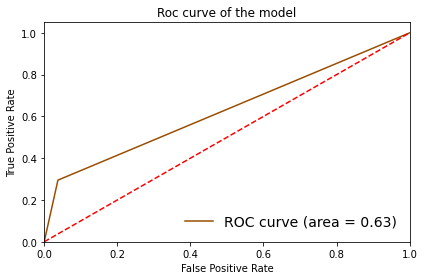


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.5830510575450906
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


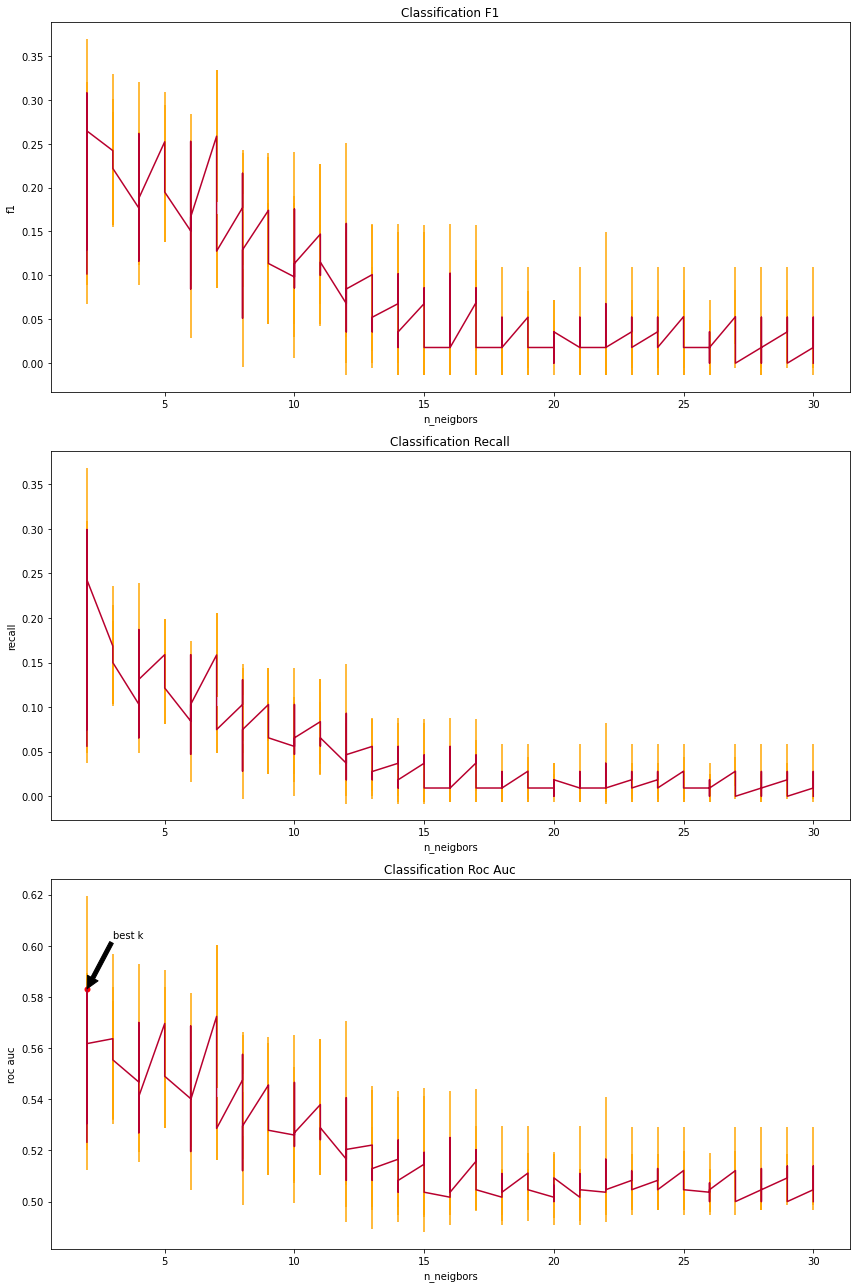



Permutation importances of the training set

OverTime                                           0.000112
StockOptionLevel                                   0.000018
NumCompaniesWorked                                 0.000015
JobInvolvement                                     0.000013
JobSatisfaction                                    0.000005
WorkLifeBalance                                    0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
RelationshipSatisfaction                           0.000000
TrainingTimesLastYear                              0.000000



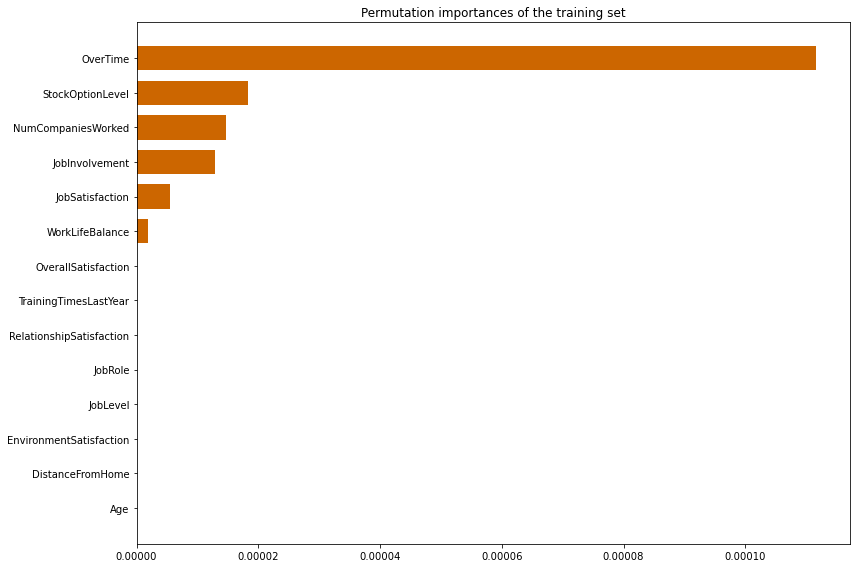



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.052631
JobSatisfaction                                    0.049945
NumCompaniesWorked                                 0.037364
WorkLifeBalance                                    0.036604
Age                                                0.036550
RelationshipSatisfaction                           0.029646
EnvironmentSatisfaction                            0.026608
DistanceFromHome                                   0.017486
OverTime                                           0.014240
JobLevel                                           0.009098
JobInvolvement                                     0.007008
JobRole                                            -0.004680
TrainingTimesLastYear                              -0.008001
OverallSatisfaction                                -0.012805



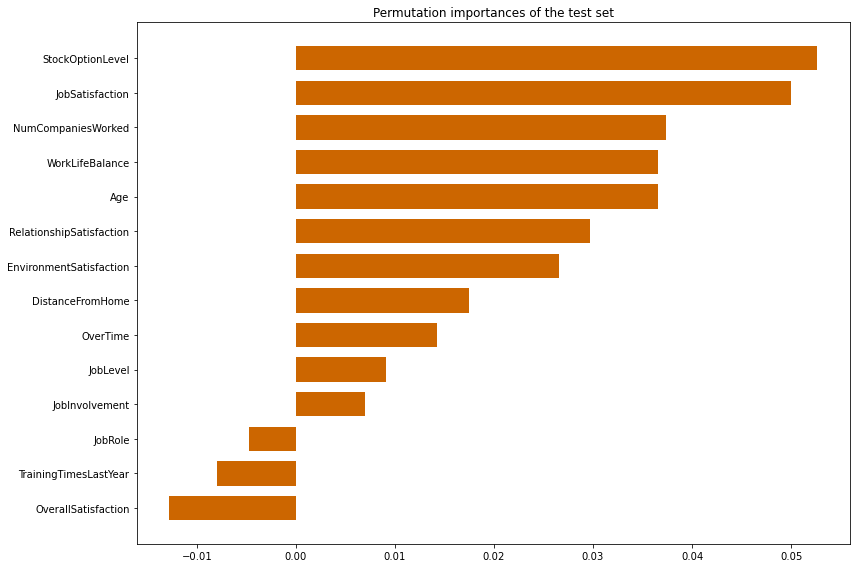



Confusion matrix


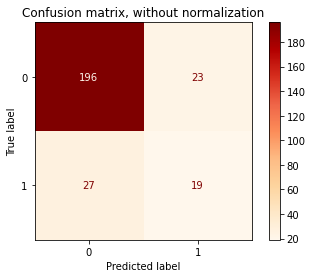

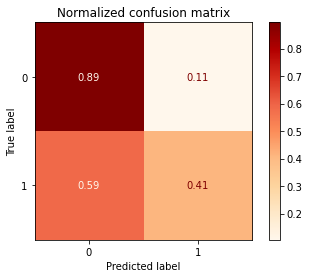


Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       219
           1       0.45      0.41      0.43        46

    accuracy                           0.81       265
   macro avg       0.67      0.65      0.66       265
weighted avg       0.80      0.81      0.81       265


Metrics

Accuracy 0.8113207547169812
F1-score [0.88687783 0.43181818]
Precision [0.87892377 0.45238095]
Recall [0.89497717 0.41304348]
Roc_auc 0.6540103236053206


Roc curve



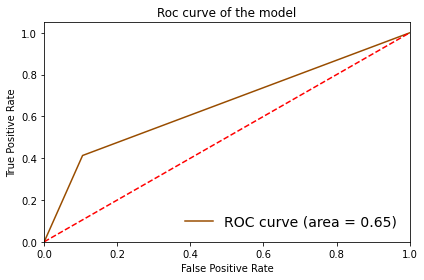


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6168452643982913
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


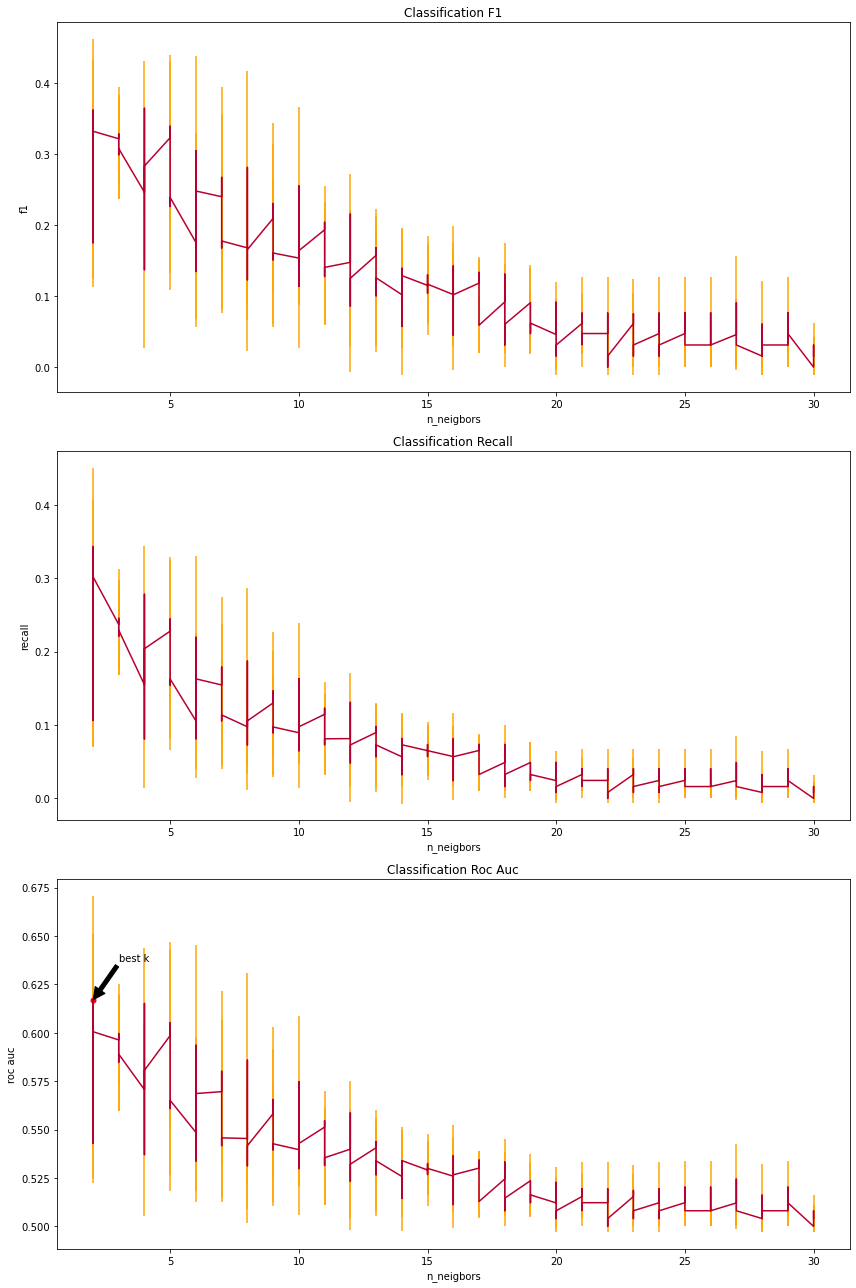



Permutation importances of the training set

OverTime                                           0.000945
EnvironmentSatisfaction                            0.000056
JobInvolvement                                     0.000041
StockOptionLevel                                   0.000021
NumCompaniesWorked                                 0.000017
TrainingTimesLastYear                              0.000010
JobSatisfaction                                    0.000006
Age                                                0.000001
DistanceFromHome                                   0.000000
JobLevel                                           0.000000
JobRole                                            0.000000
OverallSatisfaction                                0.000000
RelationshipSatisfaction                           0.000000
WorkLifeBalance                                    0.000000



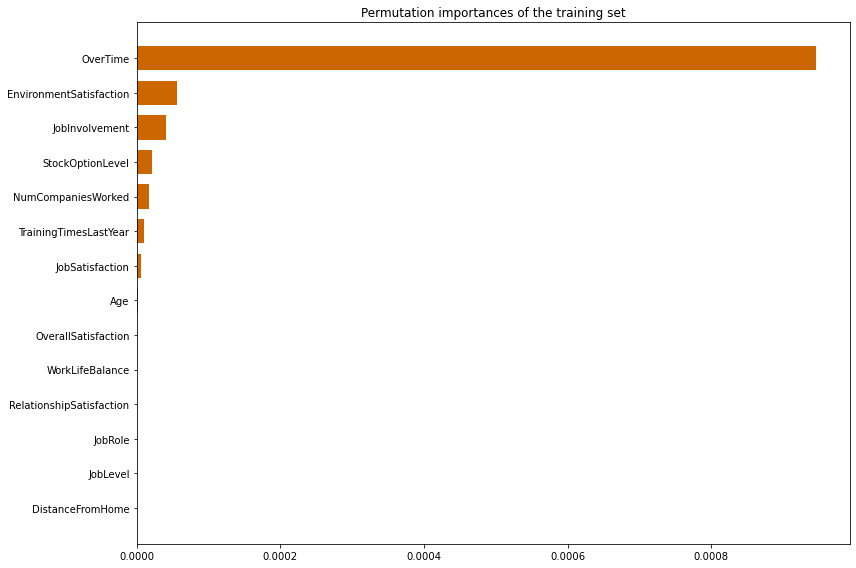



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.081960
NumCompaniesWorked                                 0.061301
WorkLifeBalance                                    0.053237
JobSatisfaction                                    0.051745
Age                                                0.034688
EnvironmentSatisfaction                            0.029331
JobLevel                                           0.026922
RelationshipSatisfaction                           0.026900
TrainingTimesLastYear                              0.023973
JobRole                                            0.021454
OverTime                                           0.020636
DistanceFromHome                                   0.010395
JobInvolvement                                     -0.005214
OverallSatisfaction                                -0.021200



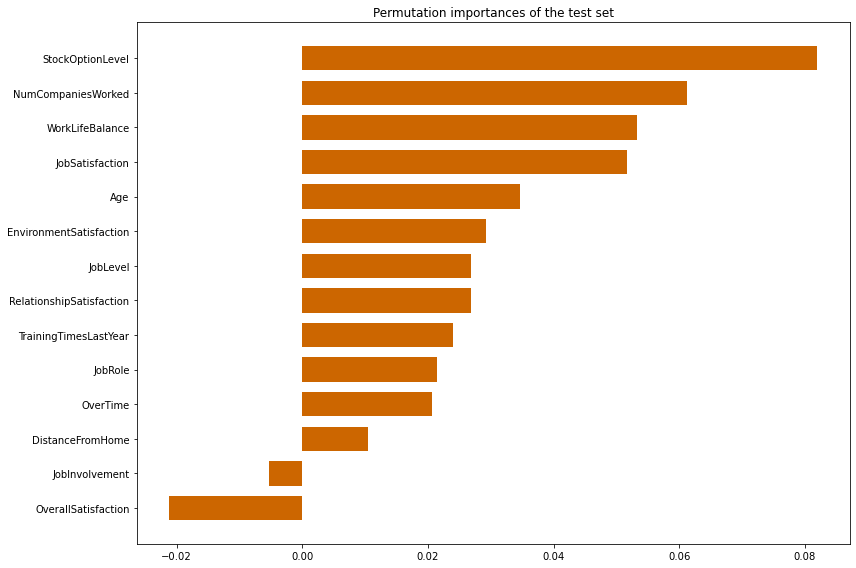



Confusion matrix


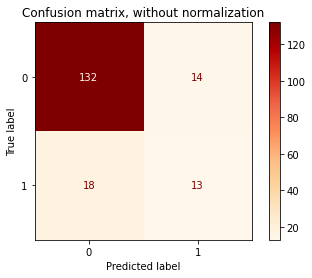

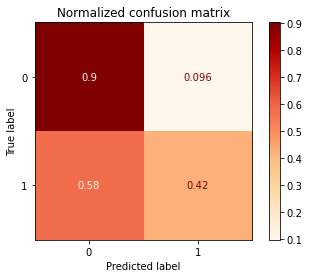


Classification report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       146
           1       0.48      0.42      0.45        31

    accuracy                           0.82       177
   macro avg       0.68      0.66      0.67       177
weighted avg       0.81      0.82      0.81       177


Metrics

Accuracy 0.8192090395480226
F1-score [0.89189189 0.44827586]
Precision [0.88       0.48148148]
Recall [0.90410959 0.41935484]
Roc_auc 0.6617322138753867


Roc curve



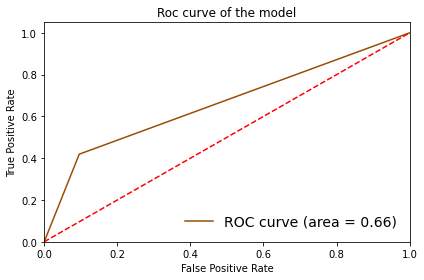


-------------------------------------------------------------------------------------------------------------



In [75]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [76]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.030716723549488054, 1.0],
   'tpr': [0.0, 0.26229508196721313, 1.0],
   'roc': 0.6157891792088626},
  '70-30': {'fpr': [0.0, 0.0502283105022831, 1.0],
   'tpr': [0.0, 0.32608695652173914, 1.0],
   'roc': 0.637929323009728},
  '80-20': {'fpr': [0.0, 0.14383561643835616, 1.0],
   'tpr': [0.0, 0.4838709677419355, 1.0],
   'roc': 0.6700176756517897}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.11945392491467577, 1.0],
   'tpr': [0.0, 0.3770491803278688, 1.0],
   'roc': 0.6287976277065965},
  '70-30': {'fpr': [0.0, 0.045662100456621, 1.0],
   'tpr': [0.0, 0.30434782608695654, 1.0],
   'roc': 0.6293428628151677},
  '80-20': {'fpr': [0.0, 0.136986301369863, 1.0],
   'tpr': [0.0, 0.4838709677419355, 1.0],
   'roc': 0.6734423331860362}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.027303754266211604, 1.0],
   'tpr': [0.0, 0.21311475409836064, 1.0],
   'roc': 0.5929054999160746},
  '70-30': {'fpr': [0.0, 0.0319634703196347, 1.0],
   'tpr': [0.0, 0.173913

In [89]:
temporal_info = {}

In [90]:
model_name = '15f numerical-encoded quantile discretized'

In [91]:
temporal_info[model_name] = scaler_dict['MaxAbsScaler']['80-20']
temporal_info

{'15f numerical-encoded quantile discretized': {'fpr': [0.0,
   0.136986301369863,
   1.0],
  'tpr': [0.0, 0.4838709677419355, 1.0],
  'roc': 0.6734423331860362}}

In [92]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['qcut']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)